In [1]:
import numpy as np
import pandas as pd

import os
import gzip

import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib import cm
from matplotlib.colors import LinearSegmentedColormap
from mpl_toolkits.basemap import Basemap
import scipy.io
import cv2


In [2]:
dir_shp = r'C:\Users\thepe\Documents\Data_Analyse\Fichiers_Geolocalisation\departements-20160218-shp'
file_shp = 'departements-20160218.shp'

In [3]:
liste_radar = {36 : 'NOYAL', 37 : 'AJACCIO', '38' : 'ST-REMY', 40 : 'ABBEVILLE', 41 : 'BORDEAUX', 42 : 'BOURGES', 43 : 'MOUCHEROTTE', 44 : 'BRIVE GREZES', 45 : 'FALAISE CAEN' , 47 : 'RADAR NANCY',
               49 : 'RADAR NIMES', 50 : 'TOULOUSE', 51 : 'TRAPPES', 52 : 'ARCIS TROYES', 53 : 'SEMBADEL', 54 : 'TREILLIERES', 55 : 'BOLLENE', 56 : 'PLABENNEC', 57 : 'OPOUL', 58 : 'ST.NIZIER',
               59 : 'COLLOBRIERES', 60 : 'VARS', 61 : 'ALERIA', 62 : 'MONTCLAR', 63 : "L'AVESNOIS", 64 : 'CHERVES', 65 : 'BLAISY-HAUT', 66 : 'MOMUY', 67 : 'MONTANCY', 68 : 'MAUREL',
               69 : 'COLOMBIS', 90 : 'GUADELOUPE LE MOULE', 91 : 'MARTINIQUE', 92 : 'LA RÉUNION COLORADO', 93: 'LA REUNION PITON VILLERS', 94 : 'NOUVELLE-CALÉDONIE NOUMEA', 96 : 'NOUVELLE-CALÉDONIE LIFOU'}


# Functions Bufr

In [4]:
class BitReader(object):
    # to read bit by bit (and not only byte by byte)
    def __init__(self, f):
        self.input = f
        self.accumulator = 0
        self.bcount = 0
        self.read = 0
        self.total_read = 0

    def __enter__(self):
        return self

    def __exit__(self, exc_type, exc_val, exc_tb):
        pass

    def _readbit(self):
        if not self.bcount:
            a = self.input.read(1)
            if a:
                self.accumulator = ord(a)
            self.bcount = 8
            self.read = len(a)
        rv = (self.accumulator & (1 << self.bcount-1)) >> self.bcount-1
        self.bcount -= 1
        return rv

    def readbits(self, n):
        self.total_read += 1
        v = 0
        while n > 0:
            v = (v << 1) | self._readbit()
            n -= 1
        
        return v

def bits2bytes(chaine):    
    ent = int(chaine,2)    
    byte_number = ent.bit_length()
    bin_array= ent.to_bytes(byte_number, "big") 
    bin_array = bin_array.strip(b'\0')
    return bin_array.decode() 
    
# to decode the real 'F' and 'X' value of a descriptor
def bytes_desc(byt):    
    if byt < 64:
        return '0-' + str(byt) + '-'
    elif byt < 128:
        return '1-' + str(byt-64) + '-'
    elif byt < 192:
        return '2-' + str(byt-128) + '-'
    else:
        return '3-' + str(byt-192) + '-'

In [5]:
# To read the csv files and put them into a dataframe
def tables_b(file_path):
    try:
        col_names_b = ['F', 'X', 'Y', 'Description', 'Unit', 'Scale', 'Reference_Value', 'Data_width_bits']
        dfb = pd.read_csv(file_path, sep = ';', header = None , names = col_names_b)
    except Exception as e:
            print(e.message)
    return dfb

def tables_d(file_path):
    col_names_d = ['F', 'X', 'Y', 'dF', 'dX', 'dY']
    dfd = pd.read_csv(file_path, sep = ';', header = None, names = col_names_d, usecols = [0,1,2,3,4,5])    
    return dfd


In [6]:
# To stock the dataframes tables into dictionary of descriptors

# Table B : descriptors with F = 0
def dico_descriptor_b(df0):
    dico_desc = {}
    try:
        for idx, row in df0.iterrows():
            dico_desc[str(row['F'])+"-"+str(row['X'])+"-"+str(row['Y'])] = {'Description' : row['Description'], 'Unit':row['Unit'], 'Scale': row['Scale'], 'Ref_Val':row['Reference_Value'], 'Data_width_bits':row['Data_width_bits']}    
    except Exception as e:
            print(e.message)
    return dico_desc

# Table D : descriptors with F = 3 (each descriptor is a list of descriptors)
def dico_descriptor_d(df0):    
    key1 = ''
    dico_desc = {}
    listed = []
    for i in range(df0.shape[0]):        
        if not(pd.isna(df0.loc[i, 'F'])) and df0.loc[i, 'F'][-1] == '3':   
            dico_desc[key1] = listed
            listed = []            
            key1 = '3-' + str(int(df0.loc[i, 'X'])) + '-' + str(int(df0.loc[i, 'Y']))
            listed = [str(int(df0.loc[i, 'dF'])) + '-' + str(int(df0.loc[i, 'dX'])) + '-' + str(int(df0.loc[i, 'dY']))]
        elif not(pd.isna(df0.loc[i,'dF'])):
            listed += [str(int(df0.loc[i, 'dF'])) + '-' + str(int(df0.loc[i, 'dX'])) + '-' + str(int(df0.loc[i, 'dY']))]
        
    dico_desc[key1] = listed
    return dico_desc


In [35]:
# to get the value, or the list of descriptors, contained in a descriptor
def descri(desc, affiche):    
    if desc in dico_l_b:
        r=dico_l_b[desc]
        if affiche:
            print(desc, ' : ', r)
        return r
    elif desc in dico_l_d:
        r=dico_l_d[desc]
        if affiche:
            print(desc, ' : ',r )
        return r
        
    elif desc in dico_m_b:
        r=dico_m_b[desc]
        if affiche:
            print(desc, ' : ', r)
        return r
    elif desc in dico_m_d:
        r=dico_m_d[desc]
        if affiche:
            print(desc, ' : ', r)
        return r
    else:
        r='UNKNOWN'
        if affiche:
            print(desc, ' UNKNOWN')
        return r

# to decode, and get the value contained in a simple descriptor (F = 0)
def simple_desc(desc_elt):
    global  reader, compte, fin_affichage, affiche_descriptors, datas_total, last_description, datas_unites #datas_prob_rain, datas_height_rain, datas_horizon_refle
    descript_elt = descri(desc_elt, not(fin_affichage) and affiche_descriptors)
    if type(descript_elt) is dict:
        if bit_new_width == 0:
            longueur = descript_elt['Data_width_bits'] + bit_width_plus
        else:
            longueur = bit_new_width
        description = descript_elt['Description']
        if not(fin_affichage) and affiche_descriptors:
            print('longueur : ', longueur, ' - Description : ', description)   
            
        tot_bits = reader.readbits(longueur)

        # apply the reference value and the scale to the value of the data pointed by the descriptor
        if bit_ref_changed:
            if desc_elt in bit_new_ref:
                val_data = (tot_bits + bit_new_ref[desc_elt])/10**(float(descript_elt['Scale'])+bit_scale_plus)
            else:
                # just to avoid an error, set a default value to 0
                val_data = 0                
        else:
            val_data = (tot_bits + float(descript_elt['Ref_Val']) )/10**(float(descript_elt['Scale'])+bit_scale_plus)

        if descript_elt['Unit'] == 'CCITT IA5': #compte==0:
            try:
                val_data = bits2bytes(bin(tot_bits))
                print('  "', bits2bytes(bin(tot_bits)), '"')            
            except:
                pass
        elif not(fin_affichage) and affiche_descriptors:
                print('  = ', val_data, descript_elt['Unit'])

        # stock the value in the list of values
        if description in datas_total:
            datas_total[description] += [val_data]
        else:
            datas_total[description] = [val_data]

        # stock the unit
        if not(description in datas_unites):            
            datas_unites[description] = descript_elt['Unit']

        # if we want to print all the details
        if description == last_description:
            fin_affichage = True
        else:
            fin_affichage = False

        last_description = description

In [8]:
# Different bufr versions
def section1_v2():
    global reader, BYTES
    x = reader.readbits(3*BYTES)
    LENGTH_1 = x
    print('Length of section 1 : ', x)
    x = reader.readbits(1*BYTES)
    BUFR_MASTER_TABLE = x
    print('Bufr master table : ', x)
    x = reader.readbits(1*BYTES)
    SUB_CENTER_ID = x
    print('Identification of originating/generating sub-centre : ', x)
    x = reader.readbits(1*BYTES)
    CENTER_ID = x
    print('Identification of originating/generating centre : ', x)
    x = reader.readbits(1*BYTES)
    print('Update sequence number : ', x)
    x = reader.readbits(1*BYTES)
    print('Optional (1) / No Optional (0) section follows : ', x)
    x = reader.readbits(1*BYTES)
    print('Data Category (Table A) : ', x)
    x = reader.readbits(1*BYTES)
    print('Data category sub-category : ', x)
    return LENGTH_1, BUFR_MASTER_TABLE, SUB_CENTER_ID, CENTER_ID

def section1_v4():
    global reader, BYTES
    x = reader.readbits(3*BYTES)
    LENGTH_1 = x
    print('Length of section 1 : ', x)
    x = reader.readbits(1*BYTES)
    BUFR_MASTER_TABLE = x
    print('Bufr master table : ', x)
    x = reader.readbits(2*BYTES)
    CENTER_ID = x
    print('Identification of originating/generating centre : ', x)
    x = reader.readbits(2*BYTES)
    SUB_CENTER_ID = x
    print('Identification of originating/generating sub-centre : ', x)
    x = reader.readbits(1*BYTES)
    print('Update sequence number : ', x)
    x = reader.readbits(1*BYTES)
    print('Optional (1) / No Optional (0) section follows : ', x)
    x = reader.readbits(1*BYTES)
    print('Data Category (Table A) : ', x)
    x = reader.readbits(1*BYTES)
    print('International data sub-category : ', x)
    x = reader.readbits(1*BYTES)
    print('Local sub-category : ', x)
    return LENGTH_1, BUFR_MASTER_TABLE, SUB_CENTER_ID, CENTER_ID

# optional section
def section2(version, LENGTH_1):
    global reader, BYTES
    if version == 2:
        lim = 17
    elif version == 4:
        lim = 22
    if LENGTH_1> lim:
        print('SECTION 2 : ')
        for k in range(LENGTH_1 - lim):
            x = reader.readbits(1*BYTES)
            print(x, ' ', chr(x))
                        
        print('FIN SECTION 2')

In [52]:
def deco_bufr():
    global FILE_PATH, BYTES, bits_data, index_descript, descriptors, compte, blocs_repetes, nb_repetitions, bit_width_plus, bit_new_width, bit_scale_plus, bit_new_ref, bit_ref_changed, datas_total, datas_unites, last_description, fin_affichage, bufr_number, datas_messages, dico_m_b, dico_m_d, dico_l_b, dico_l_d, reader
  
    FILE_PATH = os.path.join(DIR_PATH, FILE_NAME)
    BYTES = 8
    bits_data = ""
    index_descript = 0
    compte = 0
    blocs_repetes  = 0
    nb_repetitions = 0
    bit_width_plus = 0
    bit_new_width = 0
    bit_scale_plus = 0
    bit_new_ref = {}
    bit_ref_changed = False
    datas_total = {}
    last_description = ''    
    fin_affichage = False    
    bufr_number = 0
    datas_messages = []
    
    # a compressed file, use :
    with gzip.open(FILE_PATH, 'rb') as infile:
    # an uncompressed file, simply use:
    # with open(FILE_PATH, 'rb') as infile:
        
        with BitReader(infile) as reader:
            while True:
                datas_total = {}
                datas_unites = {}
                index_descript = 0
                
                # IDENTIFICATION SECTION
                try:
                    x = reader.readbits(4*BYTES)
                except:
                    break                
                if not(str(bin(x))=="0b1000010010101010100011001010010"): # entete BUFR
                    break
                print(' ----------- BEGIN OF BUFR MESSAGE n°', bufr_number, ' -----------') 
                entete = bits2bytes(bin(x))           
                print(entete)
                
                x = reader.readbits(3*BYTES)                
                print('Total length of Bufr message in bytes : ', x)
                x = reader.readbits(1*BYTES)
                print('Bufr Edition number : ', x)

                # SECTION 1
                if str(bin(x))=="0b10":
                    version = 2
                    LENGTH_1, BUFR_MASTER_TABLE, SUB_CENTER_ID, CENTER_ID = section1_v2()
                elif str(bin(x))=="0b100":
                    version = 4
                    LENGTH_1, BUFR_MASTER_TABLE, SUB_CENTER_ID, CENTER_ID = section1_v4()
                else:
                    print('Version Inconnue')
                    break         
                                    
                x = reader.readbits(1*BYTES)
                MASTER_TABLE_NUMBER = x
                print('Version number of master table used : ', x)
                x = reader.readbits(1*BYTES)
                LOCAL_TABLE_NUMBER = x
                print('Version number of local tables used : ', x)
        
                # LOAD USEFUL TABLES
                try:                
                    table_b = tables_b(os.path.join(DIR_PATH_TABLE, FIC_TAB_B.format(master=MASTER_TABLE_NUMBER)))                
                    dico_m_b = dico_descriptor_b(table_b)
                except:
                    print(' ** UNABLE TO READ MASTER TABLE B ', MASTER_TABLE_NUMBER)
                    dico_m_b = {}
                try:
                    table_d = tables_d(os.path.join(DIR_PATH_TABLE, FIC_TAB_D.format(master=MASTER_TABLE_NUMBER)))                    
                    dico_m_d = dico_descriptor_d(table_d)                    
                except:
                    print(' ** UNABLE TO READ MASTER TABLE D', MASTER_TABLE_NUMBER)
                    dico_m_d = {}
                try:                    
                    local_table_b = tables_b(os.path.join(DIR_PATH_TABLE, FIC_LOCAL_TAB_B.format(center=CENTER_ID, local=LOCAL_TABLE_NUMBER)))
                    dico_l_b = dico_descriptor_b(local_table_b)
                except:
                    print(' ** UNABLE TO READ LOCAL TABLE B ' ,CENTER_ID ,"_" , LOCAL_TABLE_NUMBER)
                    dico_l_b = {}
                try:                    
                    local_table_d = tables_d(os.path.join(DIR_PATH_TABLE, FIC_LOCAL_TAB_D.format(center=CENTER_ID, local=LOCAL_TABLE_NUMBER)))
                    dico_l_d = dico_descriptor_d(local_table_d)                    
                except:
                    print(' ** UNABLE TO READ LOCAL TABLE D ' , CENTER_ID ,"_" , LOCAL_TABLE_NUMBER)
                    dico_l_d = {}                        
                
                if version == 2:
                    x = reader.readbits(1*BYTES)
                    print('Year : ', x)
                elif version == 4:
                    x = reader.readbits(2*BYTES)
                    print('Year : ', x)
                    
                x = reader.readbits(1*BYTES)
                print('Month : ', x)
                x = reader.readbits(1*BYTES)
                print('Day : ', x)
                x = reader.readbits(1*BYTES)
                print('Hour : ', x)
                x = reader.readbits(1*BYTES)
                print('Minute : ', x)
                if version == 4:
                    x = reader.readbits(1*BYTES)
                    print('Second : ', x)                     
        
                # OPTIONAL SECTION 2                
                section2(version, LENGTH_1)  
                    
                # SECTION 3 ( Data Description )
                x = reader.readbits(3*BYTES)
                LENGTH_3 = x
                print('Length of section 3 (Data Description) : ', x)
                x = reader.readbits(1*BYTES) # SET TO 0 (reserved)
                x = reader.readbits(2*BYTES)
                print('Number of data subsets : ', x)
                x = reader.readbits(1*BYTES)
                #if version == 2:
                print('Observed/Compressed Data : ', x//128 , '/', (x//64)%2)
                
                descriptors = []
                desc = ''
                        
                for i, k in enumerate(range(LENGTH_3 - 7)):
                    x = reader.readbits(1*BYTES)
                    if i%2 == 1:
                        desc += str(x)
                        descriptors += [desc]
                        desc = ''
                    else:
                        desc = bytes_desc(x)
        
                if affiche_descriptors:
                    print('Descriptors :')
                    print(descriptors)
        
                # SECTION 4 ( Datas )
                x = reader.readbits(3*BYTES)
                LENGTH_4 = x
                print('Length of section 4 (Datas) : ', x)
                x = reader.readbits(1*BYTES) # SET TO 0 (reserved)
        
                while True:
                    if index_descript >= len(descriptors):
                        print(' END OF DESCRIPTORS ')
                        break
                    if not(fin_affichage) and affiche_descriptors:
                        print(descriptors[index_descript])                        
                                
                    if descriptors[index_descript][0] == '0': 
                        # F = 0 : single element descriptor (ref in Table B)
                        simple_desc(descriptors[index_descript])
                                
                    elif descriptors[index_descript][0] == '3': 
                        # F = 3 : list of descriptors (ref in table D)
                        descript_elt = descri(descriptors[index_descript], not(fin_affichage) and affiche_descriptors)
                        for eltk in descript_elt:
                            if affiche_descriptors:
                                print(eltk)
                        # insert the list of descriptors in place of the descriptor
                        descriptors = descriptors[:index_descript] + descript_elt + descriptors[index_descript+1:]                            
                        index_descript -= 1
                        
                    elif descriptors[index_descript][0] == '2':
                        # F = 2 : Operator descriptor  (ref in table C)                        
                        
                        new_ref = int(descriptors[index_descript].split('-')[2])        
                        if descriptors[index_descript].split('-')[1] == '1': 
                            # change data width
                            if new_ref == 0:
                                bit_width_plus = 0
                            else:
                                bit_width_plus = new_ref - 128
                        elif descriptors[index_descript].split('-')[1] == '2': 
                            # change scale
                            if new_ref == 0:
                                bit_scale_plus = 0
                            else:
                                bit_scale_plus = new_ref - 128
                        elif descriptors[index_descript].split('-')[1] == '3':
                            # change reference value
                            if 0 < new_ref:
                                bit_ref_changed = True
                                ybits = int(descriptors[index_descript].split('-')[2])
                                index_descript += 1
                                desc_new = descriptors[index_descript]
                                while desc_new != '2-3-255':
                                    result = reader.readbits(ybits)
                                    if result >= 2**(ybits-1):
                                        bit_new_ref[desc_new] = -1*(result - 2**(ybits-1))
                                    else:
                                        bit_new_ref[desc_new] = result
                                    index_descript += 1
                                    desc_new = descriptors[index_descript]   
                        
                            else:
                                bit_ref_changed = False                
                                bit_new_ref = {}

                        elif descriptors[index_descript].split('-')[1] == '8':
                            if new_ref == 0:
                                bit_new_width = 0
                            else:
                                bit_new_width = 8*new_ref                           
                        
                        
                    elif descriptors[index_descript][0] == '1': 
                        # Replication operator
                        print('* REPETITIONS *')
                        blocs_repetes = int(descriptors[index_descript].split('-')[1])
                        nbits_decal = descri(descriptors[index_descript+1], not(fin_affichage) and affiche_descriptors)['Data_width_bits']
                        nb_repetitions = reader.readbits(nbits_decal)
                        print('   number of descriptors replicated ', str(blocs_repetes), ' and number of replications = ', str(nb_repetitions))                        
                        descriptors = descriptors[:index_descript] + descriptors[index_descript+2: index_descript+2+blocs_repetes]*nb_repetitions + descriptors[index_descript+2+blocs_repetes:]
                        index_descript -= 1                               
                            
                    index_descript += 1
                    compte += 1        

                datas_messages += [datas_total]
                
                
                print(" ** END OF DATAS **")           
                    
                print('DATAS DESCRIPTORS NUMBER', len(datas_total))
                print('DATAS :')
                for key, value in datas_total.items():                     
                    if len(value) < 10:
                        # print values only for descriptors with few values
                        print(' ', key, ' : ', value, ' (', datas_unites[key] if key in datas_unites else '', ')')
                    else:
                        # lot of values : print only the number of values
                        print(' ', key, ' ( ',  len(value), ' data'+'s'*(len(value)>1) +')' )                 
                
                x = reader.readbits(4*BYTES)
                try:
                    print(' (7777 =) ', bits2bytes(bin(x))) #, 'END OF BUFR MESSAGE ', bufr_number)                 
                except:
                    print('ERROR : end of file ?')
                    break
                        
                print(' ----------- END OF BUFR MESSAGE n°', bufr_number, ' -----------') 
                bufr_number += 1
                    
        print(' END OF FILE ')
        
    nb = len(datas_messages)
    if nb > 0:
        print(' datas_messages contains ', nb, ' message'+'s'*(nb>1), 'in dictionary form, ', 'from 0 to'*(nb>1), str(nb-1)*(nb>1), 'datas_message[0]'*(nb==1))
          

# Functions Images

In [10]:
def polar_coord(data_im, center, radius):
    # transform polar coordinates to cartesian (with azimut begin with the north and turn clockwise)
    data_rad = cv2.warpPolar(data_im, center=center, maxRadius=radius, dsize=(2*radius,2*radius),flags=cv2.WARP_INVERSE_MAP + cv2.WARP_POLAR_LINEAR)
    data_rad = cv2.rotate(data_rad, cv2.ROTATE_90_COUNTERCLOCKWISE)
    return data_rad

def radar_transfo(data_im, row_im, col_im, func):
    radius = col_im
    center = (col_im, col_im)
    # apply transformation function
    f=np.vectorize(func)
    data_im = f(data_im)
    # change polar to cartesian coordinates
    data_rad = polar_coord(data_im, center, radius)
    return data_rad   

def radar_transfo_bruit(data_im, row_im, col_im, func, bruit):
    # same function as above, but with a 'bruit' parameter
    radius = col_im
    center = (col_im, col_im)
    # apply transformation function
    f=np.vectorize(func)
    data_im = f(data_im, bruit)    
    # change polar to cartesian coordinates
    data_rad = polar_coord(data_im, center, radius)
    return data_rad 

# datas already cartesian, just apply a function transformation
def radar_coord_reflSigma(data_im, row_im, col_im):
    data_rad = []
    for r in range(row_im):
        data_1 = []
        for c in range(col_im):
            data_1 += [reflSigma(data_im[r][c])]
        data_rad += [data_1]
    return data_rad

def radar_coord_adv(data_im, row_im, col_im):
    data_rad = []
    for r in range(row_im):
        data_1 = []
        for c in range(col_im):
            data_1 += [adv(data_im[r][c])]
        data_rad += [data_1]
    return data_rad


In [11]:
# PAM and PAG functions
def reflZ(pixel, bruiti): 
    if pixel == 0:
        return bruiti
    if pixel == 1:
        return bruiti + 3
    if pixel == 2:
        return -9
    if pixel <= 79:
        return pixel - 11
    return np.nan

def reflSigma(pixel): 
    if pixel == 0:
        return 0
    if pixel< 63:
        return pixel*0.25
    if pixel == 63:
        return 15.75
    return np.nan

def correl(pixel):
    if pixel == 0:
        return 0.31
    if pixel< 79:
        return 0.3+pixel/100 
    return np.nan    

def phidp(pixel):   
    if pixel< 360:
        return pixel    
    return np.nan

def adv(pixel):   
    if pixel <= 1:
        return -328
    if pixel <=65533:
        return pixel/100-328
    if pixel == 65534:
        return np.nan
    return 328

def refldiff(pixel):   
    if pixel <= 199:
        return -10+pixel/10    
    return np.nan

def vitvraipol(pixel):
    if pixel == 0:
        return -60
    if pixel <= 241:
        return -60+0.5*pixel
    return np.nan

# PROGRAM FOR MOSAIQUE (or reflectivity of individual radar)

In [50]:
# VARIABLES TO DECLARE

# bufr file to decode
DIR_PATH = r'C:\Users\thepe\Documents\Data_Analyse\Meteo_France_API'
FILE_NAME = 'T_IMFR27_C_LFPW_20240126080000.bufr.gz'
#FILE_NAME = 'T_IPSR51_C_LFPW_20240129132500.bufr.gz'
#FILE_NAME = 'T_IPSR42_C_LFPW_20240131074000.bufr.gz'
#FILE_NAME = 'T_IPSR92_C_LFPW_20240131080000.bufr.gz'
FILE_NAME = 'T_IPSR58_C_LFPW_20240202181500.bufr.gz'


# directory of the tables and local tables
DIR_PATH_TABLE = r'C:\Users\thepe\Documents\BUFR32\MeteoFranceTables'

# if you want to see all the descriptors (but lot of prints !!)
affiche_descriptors = False

FIC_TAB_B = 'bufrtabb_{master}.csv'
FIC_TAB_D = 'bufrtabd_{master}.csv'
FIC_LOCAL_TAB_B = 'localtabb_{center}_{local}.csv'
FIC_LOCAL_TAB_D = 'localtabd_{center}_{local}.csv'

In [51]:
# Main Program
deco_bufr()

 ----------- BEGIN OF BUFR MESSAGE n° 0  -----------
BUFR
Total length of Bufr message in bytes :  754080
Bufr Edition number :  4
Length of section 1 :  22
Bufr master table :  0
Identification of originating/generating centre :  85
Identification of originating/generating sub-centre :  0
Update sequence number :  0
Optional (1) / No Optional (0) section follows :  0
Data Category (Table A) :  6
International data sub-category :  0
Local sub-category :  3
Version number of master table used :  16
Version number of local tables used :  14
Year :  2024
Month :  2
Day :  2
Hour :  18
Minute :  15
Second :  0
Length of section 3 (Data Description) :  162
Number of data subsets :  1
Observed/Compressed Data :  1 / 0
Length of section 4 (Datas) :  753884
  " ZBAS_CART_1KM_RADAR_NIZI "
new ref  -----------  12 96
  " SERVAL_2.3.1 "
new ref  -----------  0 0
* REPETITIONS *
   number of descriptors replicated  1  and number of replications =  3
* REPETITIONS *
   number of descriptors replica

## Maps for Mosaique

## Probability of rain (only for Mosaique, not with individual radar)

In [ ]:
cmap_prob = colors.ListedColormap(['white','silver', 'darkslateblue', 'mediumblue','dodgerblue', 
                              'skyblue','olive','mediumseagreen','cyan','lime','yellow',
                              'khaki','burlywood','orange','pink','tomato', 'orangered', 'r', 'red', 'brown'])
bounds_prob = [0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.40, 0.45, 0.50, 0.55, 0.6, 0.65, 0.70, 0.75, 0.80, 0.85, 0.90, 0.95, 1]
norm_prob = colors.BoundaryNorm(bounds_prob, cmap_prob.N)

ltop=bounds_prob[::2]           # labels appear on top
lbot = [x if i%2==1 else '' for i, x in enumerate(bounds_prob) ]
clabel_prob = 'Probability of Rain'

rows = int(datas_messages[0]['Number of pixels per row'][0]) #int(datas_total['Number of pixels per row'][0])
cols = int(datas_messages[0]['Number of pixels per column'][0])

data1 = np.reshape(datas_messages[0]['Probability of rain'], (rows, cols))

my_dpi = 96
fig, ax = plt.subplots(figsize=(3000/my_dpi, 3000/my_dpi), dpi = my_dpi)
fig.subplots_adjust()
p = ax.imshow(data1, cmap = cmap_prob, norm=norm_prob)
plt.axis('off')
cbar = plt.colorbar(p, cmap=cmap_prob, norm=norm_prob, boundaries=bounds_prob, ticks=bounds_prob, location="bottom", pad=0.03, aspect=50)
ax.set_title(clabel_prob, fontsize = 40)
cbar.ax.set_xticklabels(lbot)
cbar.ax.tick_params(size=0) # cacher les ticks
for ii, li in enumerate(ltop):
    cbar.ax.text(2*ii/(len(bounds_prob)-1), 1.2, str(li), transform=cbar.ax.transAxes, va='bottom', ha='center')

#plt.savefig(FILE_NAME.split('.')[0]+'_prob_rain.png', dpi = my_dpi*2)

### version with contours background for Metropole (approximative)

Text(0.5, 1.0, 'Probability of Rain(Metropole) - 2024/01/26-08h00')

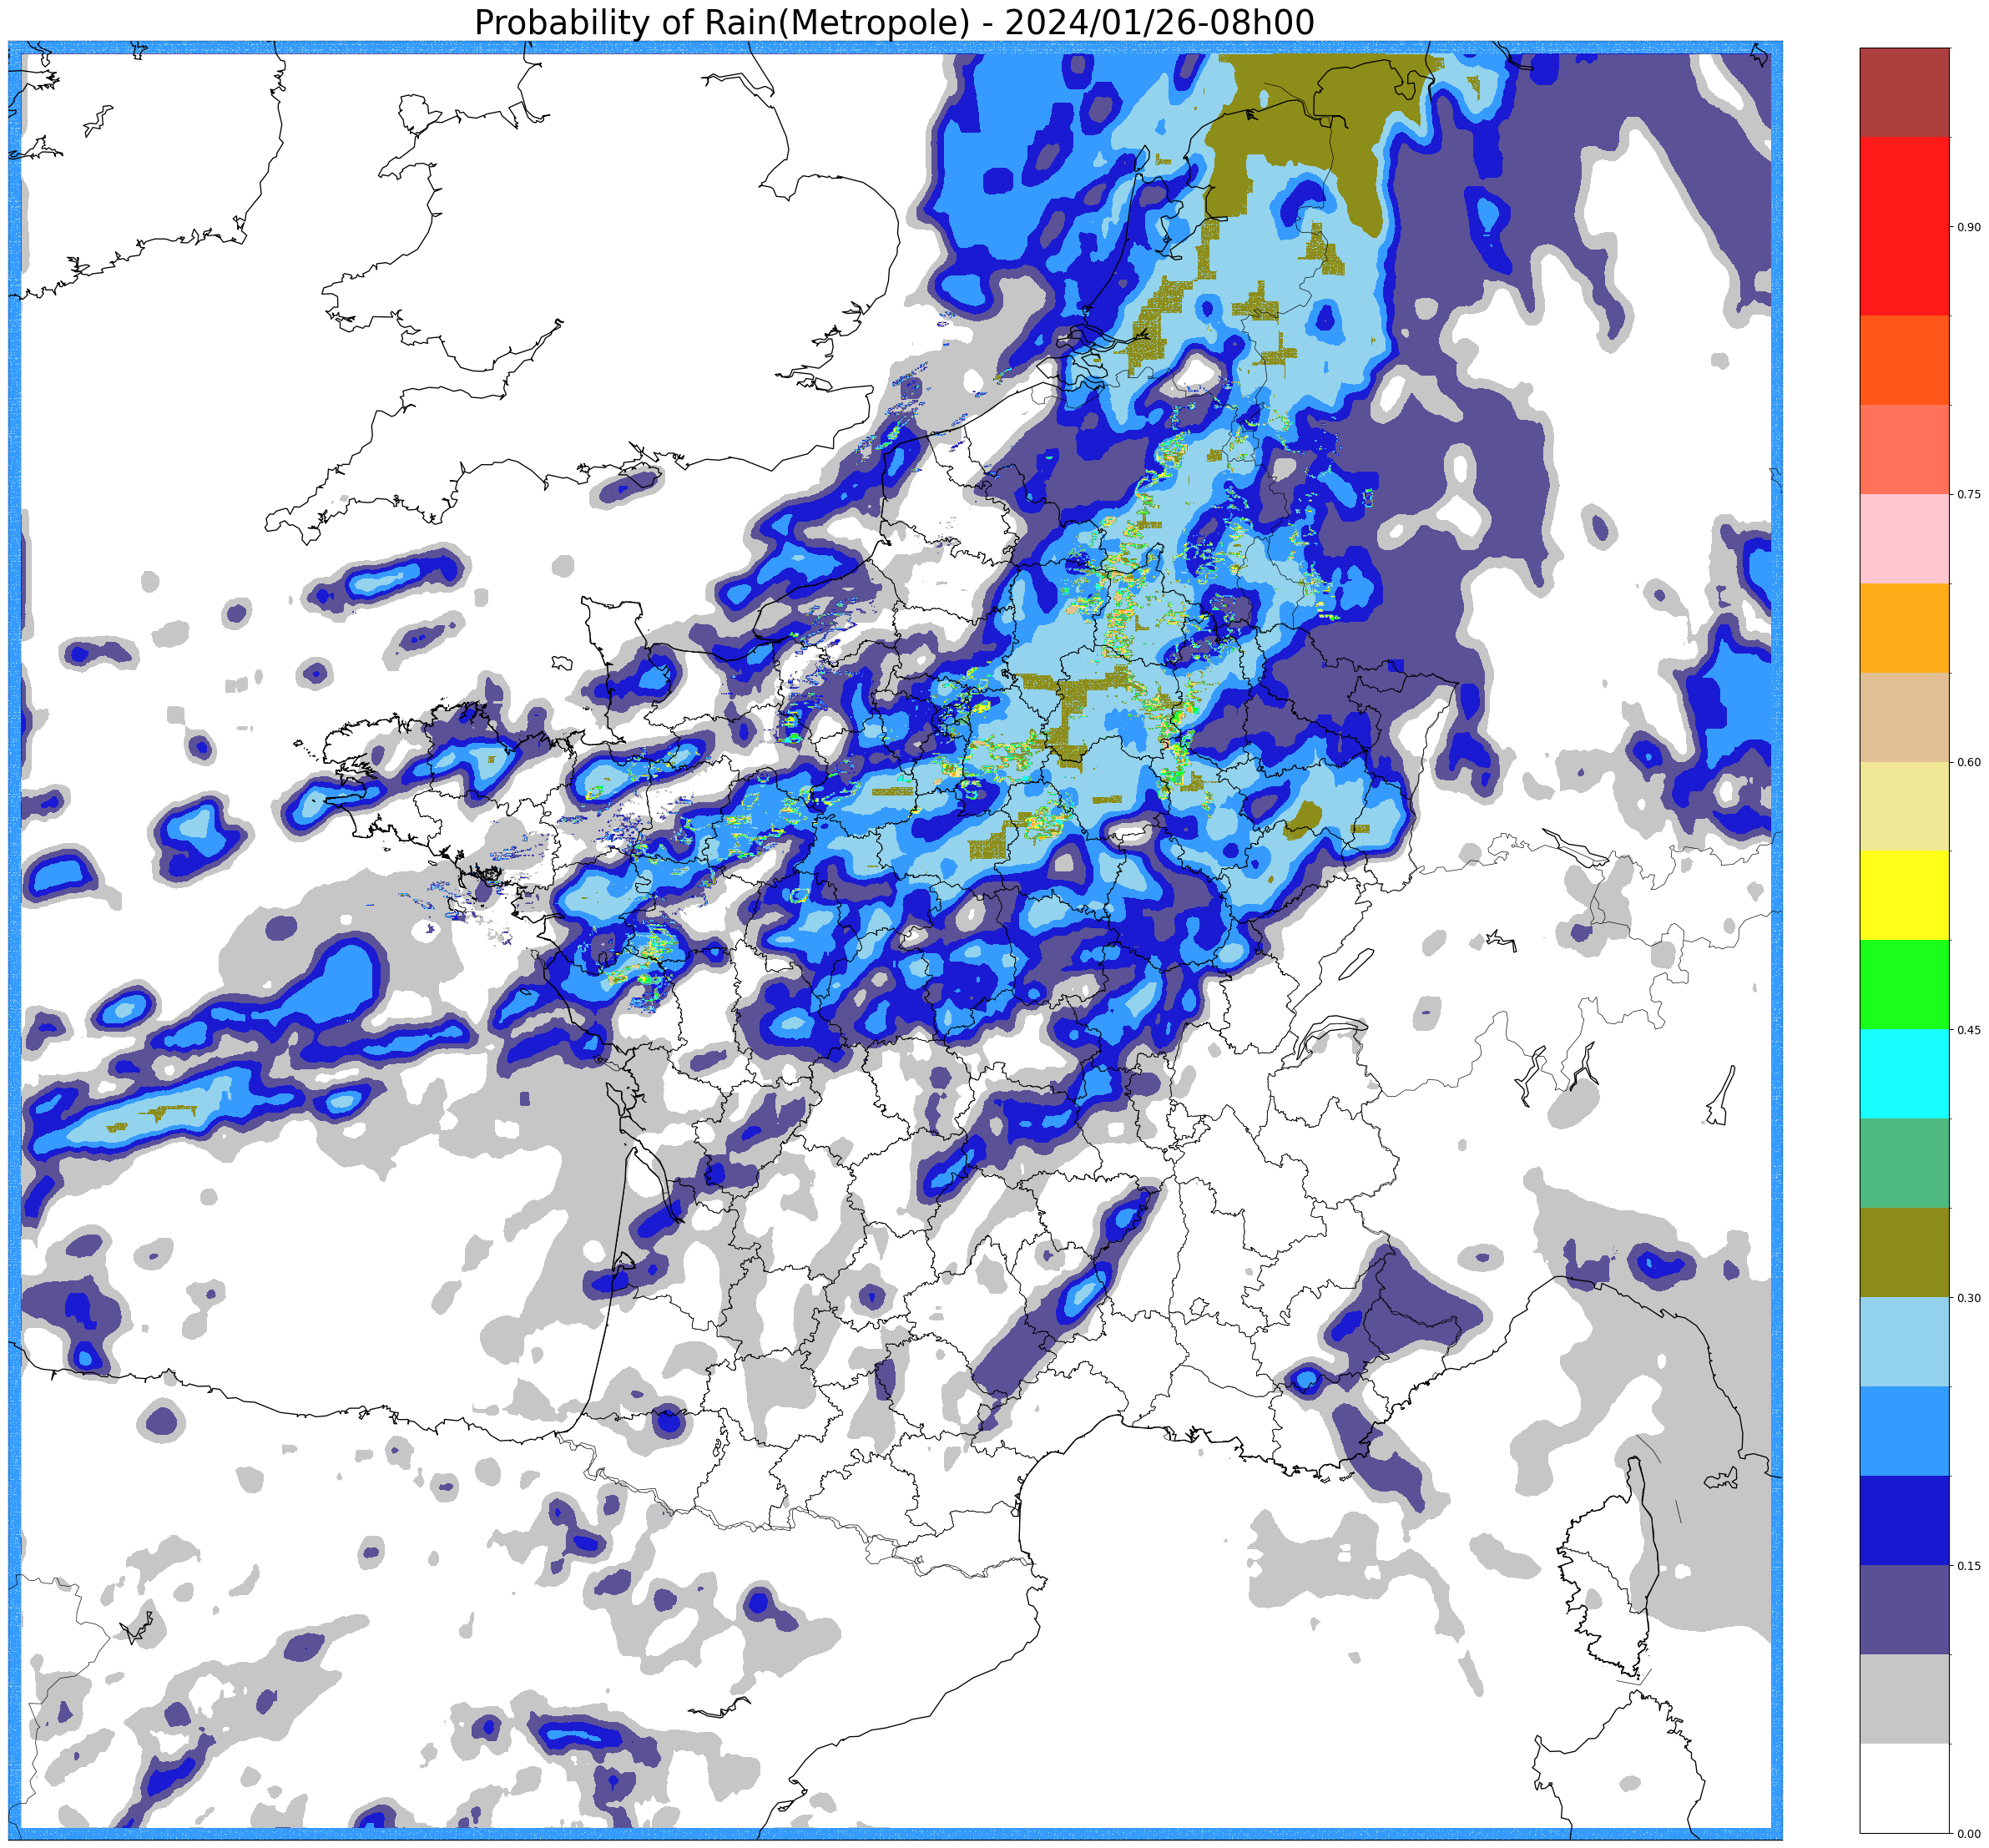

In [92]:
lat_center = 47
lon_center = 2
lat_center_plus = 53.5 
lat_center_moins = 40  
lon_center_plus = 13
lon_center_moins = -7

cmap_prob = colors.ListedColormap(['white','silver', 'darkslateblue', 'mediumblue','dodgerblue', 
                              'skyblue','olive','mediumseagreen','cyan','lime','yellow',
                              'khaki','burlywood','orange','pink','tomato', 'orangered', 'r', 'red', 'brown'])
bounds_prob = [0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.40, 0.45, 0.50, 0.55, 0.6, 0.65, 0.70, 0.75, 0.80, 0.85, 0.90, 0.95, 1]
norm_prob = colors.BoundaryNorm(bounds_prob, cmap_prob.N)
date_radar = FILE_NAME.split('_')[4]
clabel_prob = 'Probability of Rain(Metropole) - ' + str(date_radar[:4]) + '/' + str(date_radar[4:6]) + '/' + str(date_radar[6:8]) + '-' + str(date_radar[8:10]) + 'h' + str(date_radar[10:12]) 

rows = int(datas_messages[0]['Number of pixels per row'][0]) #int(datas_total['Number of pixels per row'][0])
cols = int(datas_messages[0]['Number of pixels per column'][0])
data1 = np.reshape(datas_messages[0]['Probability of rain'], (rows, cols))

my_dpi = 96
fig, ax = plt.subplots(1,1, figsize=(3000/my_dpi, 3000/my_dpi), dpi = my_dpi)
map = Basemap(llcrnrlon=lon_center_moins,llcrnrlat=lat_center_moins, urcrnrlon = lon_center_plus, urcrnrlat = lat_center_plus,
             resolution='i', projection='tmerc', lat_0 = lat_center, lon_0 = lon_center)
map.drawmapboundary(color = 'black')
map.drawcoastlines(color = 'black', zorder=5)
map.drawcountries(color = 'black', zorder=6)
map.readshapefile(os.path.join(dir_shp, file_shp[:-4]), 'departements', color = 'black', zorder = 7)
p=map.imshow(data1[::-1], cmap=cmap_prob, norm=norm_prob,  alpha=0.9, zorder=3)

cbar2 = fig.colorbar(p, ax=ax,fraction=0.046, pad=0.04)
ax.set_title(clabel_prob, fontsize = 30)

# save the figure
#plt.savefig(FILE_NAME.split('.')[0] + '_prob_rain.png', dpi = my_dpi*2)

## Height (Mosaique or Individual Radar)

In [ ]:
cmap_h = colors.ListedColormap(['silver','white', 'darkslateblue', 'mediumblue','dodgerblue', 
                              'skyblue','olive','mediumseagreen','cyan','lime','yellow',
                              'khaki','burlywood','orange','brown','pink','red','plum', 'black'])
bounds_h = [-1, 0, 20, 40, 60, 80, 100, 150,200, 500,1000, 2000, 3000, 4000, 5000, 5500, 6000, 6500, 7500, 50000]
norm_h = colors.BoundaryNorm(bounds_h, cmap_h.N)


ltop=bounds_h[::2]           # labels appear on top
lbot = [x if i%2==1 else '' for i, x in enumerate(bounds_h) ]
clabel_h = 'Height'

rows = int(datas_messages[0]['Number of pixels per row'][0])
cols = int(datas_messages[0]['Number of pixels per column'][0])

data1 = np.reshape(datas_messages[0]['Height'], (rows, cols))

my_dpi = 96
fig, ax = plt.subplots(figsize=(3000/my_dpi, 3000/my_dpi), dpi = my_dpi)
fig.subplots_adjust()

p = ax.imshow(data1, cmap = cmap_h, norm=norm_h)
plt.axis('off')
cbar = plt.colorbar(p, cmap=cmap_h, norm=norm_h, boundaries=bounds_h, ticks=bounds_h, location="bottom", pad=0.03, aspect=50)
ax.set_title(clabel_h, fontsize = 20)
cbar.ax.set_xticklabels(lbot)
cbar.ax.tick_params(size=0) # cacher les ticks
vmin=cbar.norm.vmin
vmax=cbar.norm.vmax
for ii, li in enumerate(ltop):
    cbar.ax.text(2*ii/(len(bounds_h)-1), 1.2, str(li), transform=cbar.ax.transAxes, va='bottom', ha='center')
    
#plt.savefig(FILE_NAME.split('.')[0] + '_height.png', dpi = my_dpi*2)

### version with contours background for Metropole (approximative)

In [ ]:
Metropole = True

if Metropole:
    lat_center = 47
    lon_center = 2
    lat_center_plus = 53.5
    lat_center_moins = 40
    lon_center_plus = 13
    lon_center_moins = -7
else:
    lat_center = datas_messages[0]['Latitude (high accuracy)'][0]
    lon_center = datas_messages[0]['Longitude (high accuracy)'][0]
    distance_max = datas_messages[0]["Distance Ouest-Est du coin Nord-Ouest de l'image au radar"][0] /1000
    # estimation at the corresponding latitude
    lat_center_plus = lat_center + distance_max/111.2
    lat_center_moins = lat_center - distance_max/111.2
    lon_center_plus = lon_center + distance_max/(111.2*np.cos(lat_center*np.pi/180))
    lon_center_moins = lon_center - distance_max/(111.2*np.cos(lat_center*np.pi/180))


cmap_h = colors.ListedColormap(['silver','white', 'darkslateblue', 'mediumblue','dodgerblue', 
                              'skyblue','olive','mediumseagreen','cyan','lime','yellow',
                              'khaki','burlywood','orange','brown','pink','red','plum', 'black'])
bounds_h = [-1, 0, 20, 40, 60, 80, 100, 150,200, 500,1000, 2000, 3000, 4000, 5000, 5500, 6000, 6500, 7500, 50000]
norm_h = colors.BoundaryNorm(bounds_h, cmap_h.N)


rows = int(datas_messages[0]['Number of pixels per row'][0]) #int(datas_total['Number of pixels per row'][0])
cols = int(datas_messages[0]['Number of pixels per column'][0])

data1 = np.reshape(datas_messages[0]['Height'], (rows, cols))

date_radar = FILE_NAME.split('_')[4]
clabel_h = 'Height - ' + str(date_radar[:4]) + '/' + str(date_radar[4:6]) + '/' + str(date_radar[6:8]) + '-' + str(date_radar[8:10]) + 'h' + str(date_radar[10:12]) 

my_dpi = 96
fig, ax = plt.subplots(1,1, figsize=(3000/my_dpi, 3000/my_dpi), dpi = my_dpi)

map = Basemap(llcrnrlon=lon_center_moins,llcrnrlat=lat_center_moins, urcrnrlon = lon_center_plus, urcrnrlat = lat_center_plus,
             resolution='i', projection='tmerc', lat_0 = lat_center, lon_0 = lon_center)


map.drawmapboundary(color = 'black')
map.drawcoastlines(color = 'black', zorder=5)
map.drawcountries(color = 'black', zorder=6)

map.readshapefile(os.path.join(dir_shp, file_shp[:-4]), 'departements', color = 'black', zorder = 7)

# Use imshow()
p=map.imshow(data1[::-1], cmap=cmap_h, norm=norm_h,  alpha=0.9, zorder=3)

fig.colorbar(p, ax=ax,fraction=0.046, pad=0.04)
ax.set_title(clabel_h, fontsize = 20)

# save the figure
  
#plt.savefig(FILE_NAME.split('.')[0] + '_height.png', dpi = my_dpi*2)

## Horizontal Reflectivity (Mosaique or Individual Radar)

In [ ]:
cmap_r = colors.ListedColormap(['silver','white', 'darkslateblue', 'mediumblue','dodgerblue', 
                              'skyblue','olive','mediumseagreen','cyan','lime','yellow',
                              'khaki','burlywood','orange','brown','pink','red','plum', 'black'])
bounds_r = [-40, 8, 10, 12, 14,16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44]
norm_r = colors.BoundaryNorm(bounds_r, cmap_r.N)

ltop=bounds_r[::2]           # labels appear on top
lbot = [x if i%2==1 else '' for i, x in enumerate(bounds_r) ]
clabel_r = 'Horizontal Reflectivity (dBZ)'

rows = int(datas_messages[0]['Number of pixels per row'][0])
cols = int(datas_messages[0]['Number of pixels per column'][0])

data1 = np.reshape(datas_messages[0]['Horizontal reflectivity'], (rows, cols))

my_dpi = 96
fig, ax = plt.subplots(figsize=(3000/my_dpi, 3000/my_dpi), dpi = my_dpi)

fig.subplots_adjust()

p = ax.imshow(data1, cmap = cmap_r, norm=norm_r)
plt.axis('off')
cbar = plt.colorbar(p, cmap=cmap_r, norm=norm_r, boundaries=bounds_r, ticks=bounds_r, location="bottom", pad=0.03, aspect=50)
ax.set_title(clabel_r, fontsize = 20)
cbar.ax.set_xticklabels(lbot)
cbar.ax.tick_params(size=0) # cacher les ticks
vmin=cbar.norm.vmin
vmax=cbar.norm.vmax
for ii, li in enumerate(ltop):
    cbar.ax.text(2*ii/(len(bounds_r)-1), 1.2, str(li), transform=cbar.ax.transAxes, va='bottom', ha='center')

#plt.savefig(FILE_NAME.split('.')[0] + '_dBZ.png',  dpi = my_dpi*2)

### version with contours background for Metropole (approximative)

Text(0.5, 1.0, 'Horizontal Reflectivity (Metropole) - 2024/01/26-08h00')

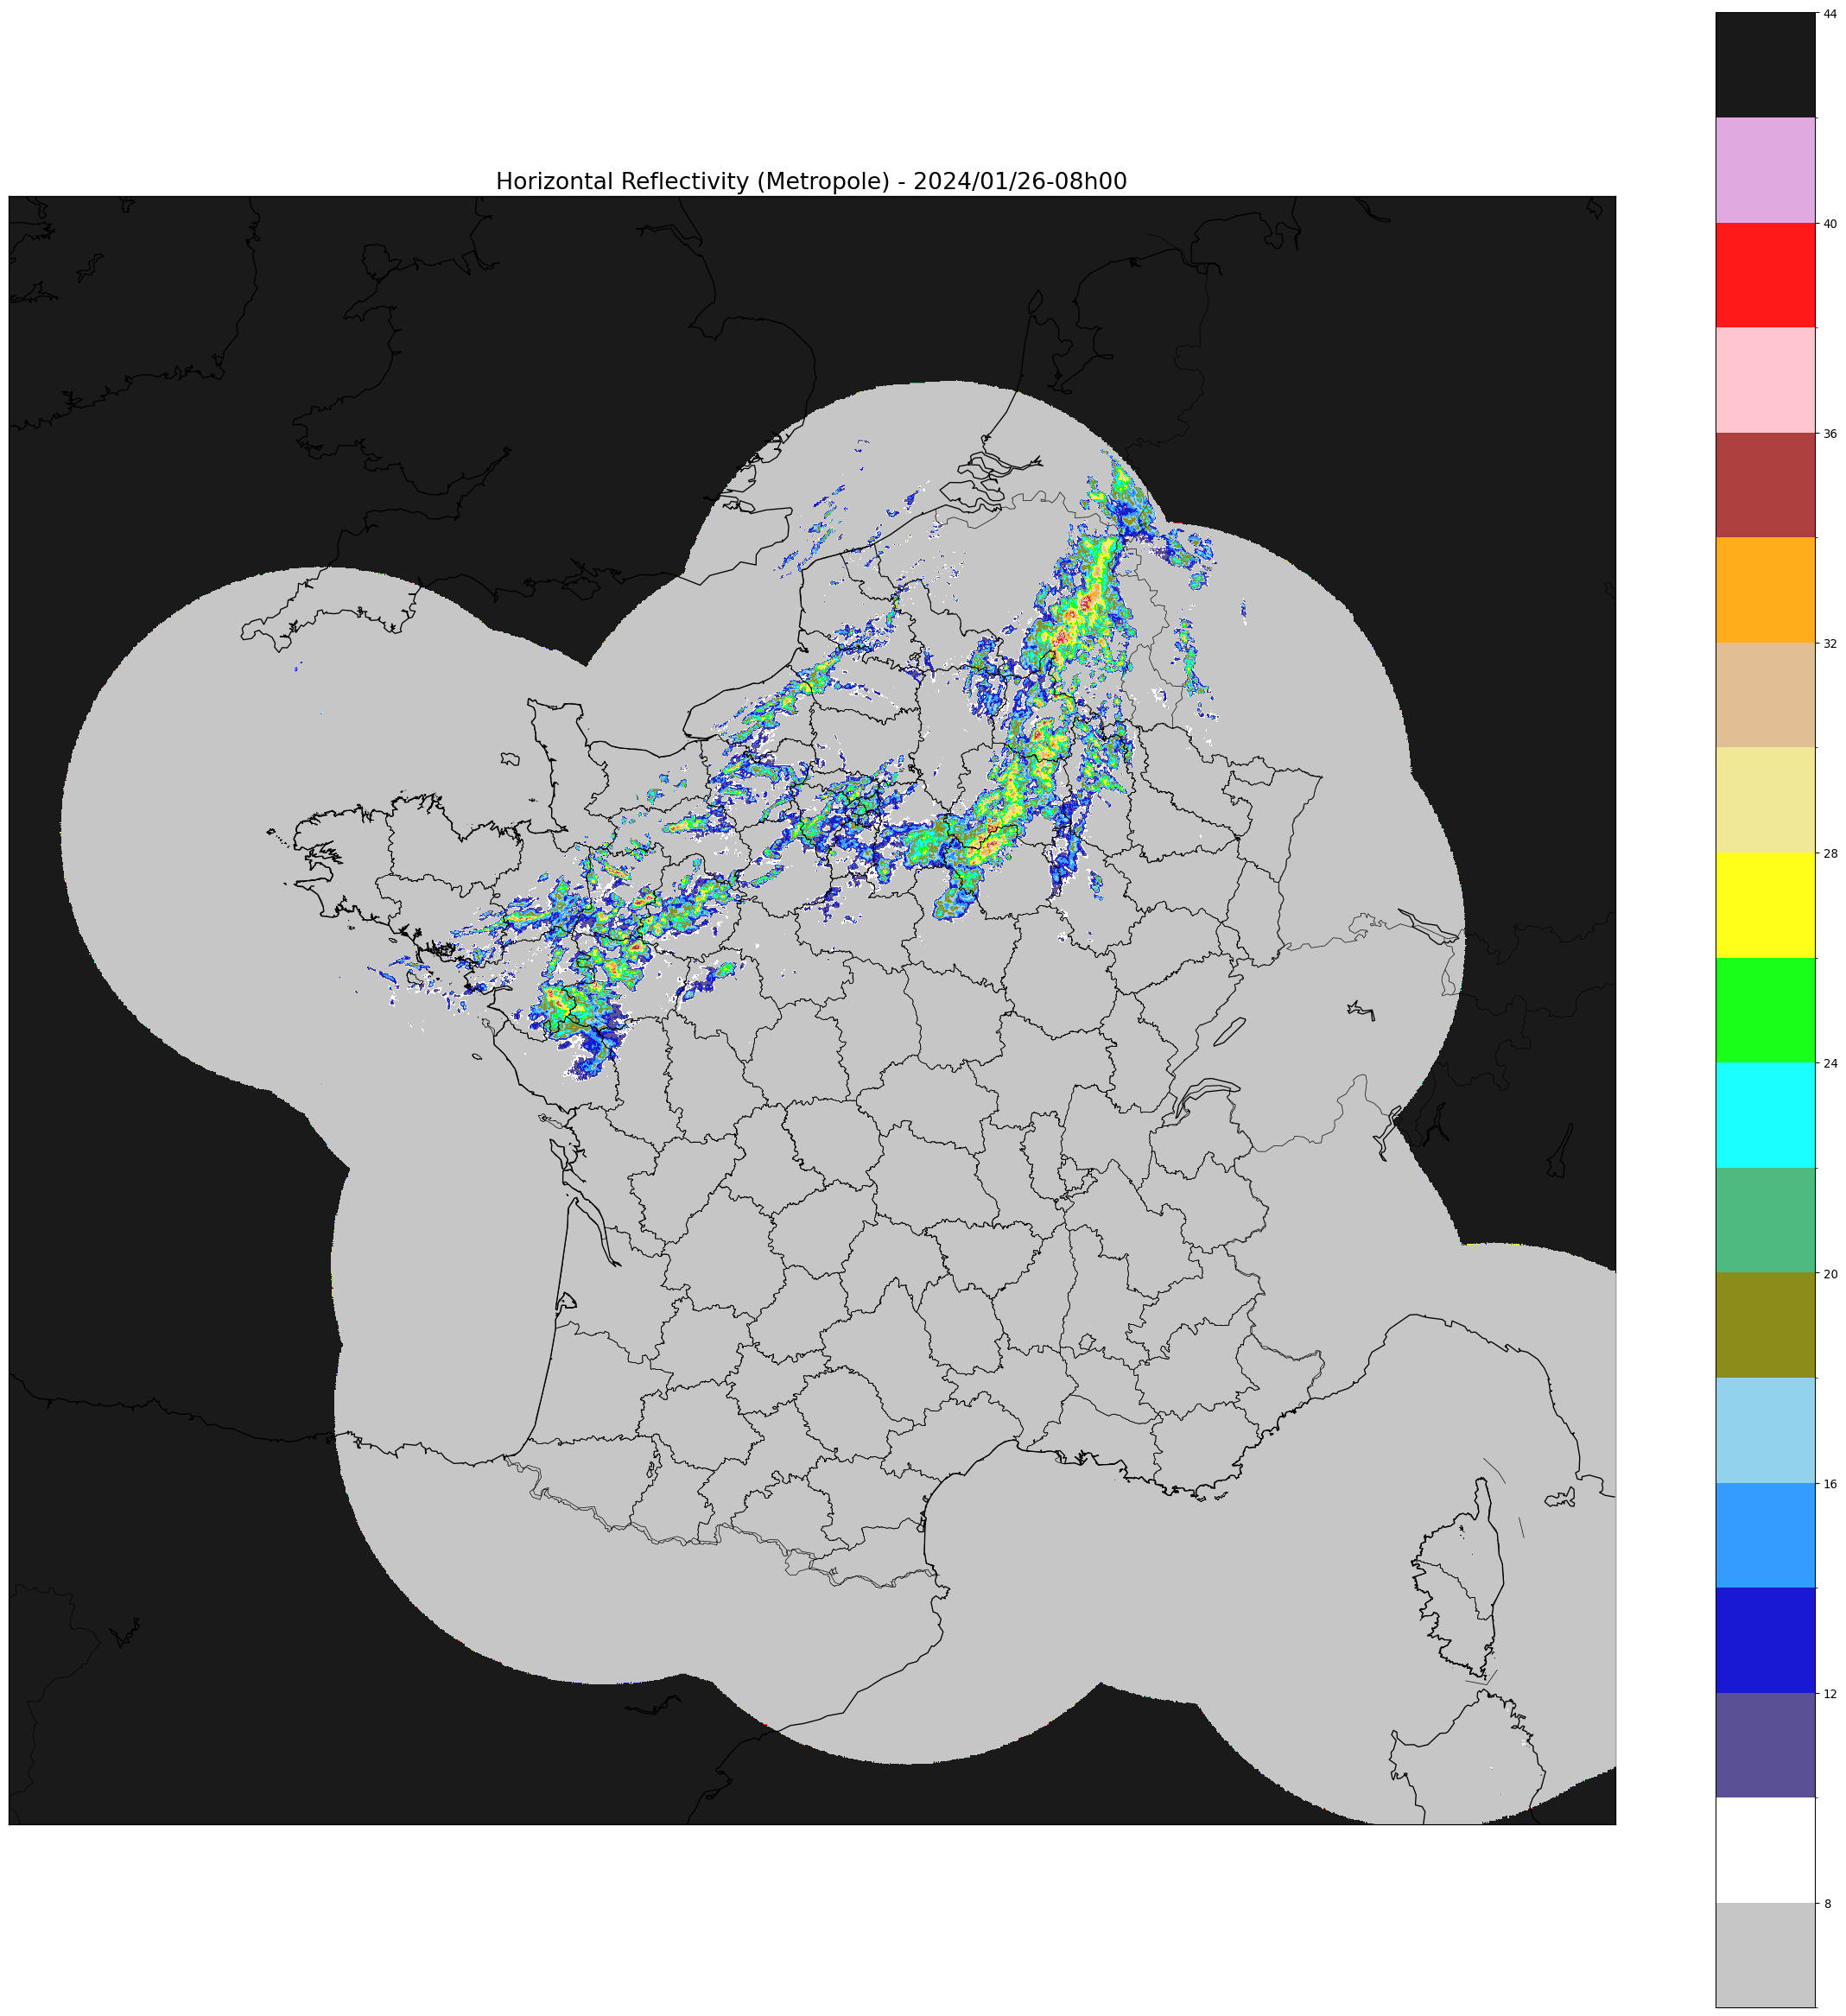

In [97]:
Metropole = True

if Metropole:
    lat_center = 47
    lon_center = 2
    lat_center_plus = 53.5
    lat_center_moins = 40
    lon_center_plus = 13
    lon_center_moins = -7
else:
    lat_center = datas_messages[0]['Latitude (high accuracy)'][0]
    lon_center = datas_messages[0]['Longitude (high accuracy)'][0]
    distance_max = datas_messages[0]["Distance Ouest-Est du coin Nord-Ouest de l'image au radar"][0] /1000
    # estimation at the corresponding latitude
    lat_center_plus = lat_center + distance_max/111.2
    lat_center_moins = lat_center - distance_max/111.2
    lon_center_plus = lon_center + distance_max/(111.2*np.cos(lat_center*np.pi/180))
    lon_center_moins = lon_center - distance_max/(111.2*np.cos(lat_center*np.pi/180))

cmap_r = colors.ListedColormap(['silver','white', 'darkslateblue', 'mediumblue','dodgerblue', 
                              'skyblue','olive','mediumseagreen','cyan','lime','yellow',
                              'khaki','burlywood','orange','brown','pink','red','plum', 'black'])
bounds_r = [-40, 8, 10, 12, 14,16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44]
norm_r = colors.BoundaryNorm(bounds_r, cmap_r.N)


rows = int(datas_messages[0]['Number of pixels per row'][0]) #int(datas_total['Number of pixels per row'][0])
cols = int(datas_messages[0]['Number of pixels per column'][0])

data1 = np.reshape(datas_messages[0]['Horizontal reflectivity'], (rows, cols))

date_radar = FILE_NAME.split('_')[4]
clabel_r = 'Horizontal Reflectivity (Metropole) - ' + str(date_radar[:4]) + '/' + str(date_radar[4:6]) + '/' + str(date_radar[6:8]) + '-' + str(date_radar[8:10]) + 'h' + str(date_radar[10:12]) 

my_dpi = 96
fig, ax = plt.subplots(1,1, figsize=(3000/my_dpi, 3000/my_dpi), dpi = my_dpi)

map = Basemap(llcrnrlon=lon_center_moins,llcrnrlat=lat_center_moins, urcrnrlon = lon_center_plus, urcrnrlat = lat_center_plus,
             resolution='i', projection='tmerc', lat_0 = lat_center, lon_0 = lon_center)


map.drawmapboundary(color = 'black')
map.drawcoastlines(color = 'black', zorder=5)
map.drawcountries(color = 'black', zorder=6)

map.readshapefile(os.path.join(dir_shp, file_shp[:-4]), 'departements', color = 'black', zorder = 7)

# Use imshow()
p=map.imshow(data1[::-1], cmap=cmap_r, norm=norm_r,  alpha=0.9, zorder=3)

fig.colorbar(p, ax=ax,fraction=0.046, pad=0.04)
ax.set_title(clabel_r, fontsize = 20)

# save the figure
  
#plt.savefig(FILE_NAME.split('.')[0] + '_Metropole_Horizontal_Reflectivity_dBZ.png',  dpi = my_dpi*2)

# PROGRAM FOR INDIVIDUALS RADARS (PAM)

In [53]:
# bufr file to decode
DIR_PATH = r'C:\Users\thepe\Documents\Data_Analyse\Meteo_France_API'
FILE_NAME = 'T_PAMF58_C_LFPW_20240110195000.bufr.gz'
#FILE_NAME = 'T_PAMA55_C_LFPW_20240129162500.bufr.gz'
#FILE_NAME = 'T_PAMA51_C_LFPW_20240129133000.bufr.gz'
#FILE_NAME = 'T_PAMA65_C_LFPW_20240130101000.bufr.gz'
#FILE_NAME = 'T_PAMC42_C_LFPW_20240131074500.bufr.gz'
#FILE_NAME = 'T_PAMC92_C_FMEE_20240131101500.bufr.gz'


# directory of the tables and local tables
DIR_PATH_TABLE = r'C:\Users\thepe\Documents\BUFR32\MeteoFranceTables'

# if you want to see all the descriptors (but lot of prints !!)
affiche_descriptors = False

FIC_TAB_B = 'bufrtabb_{master}.csv'
FIC_TAB_D = 'bufrtabd_{master}.csv'
FIC_LOCAL_TAB_B = 'localtabb_{center}_{local}.csv'
FIC_LOCAL_TAB_D = 'localtabd_{center}_{local}.csv'


In [54]:
deco_bufr()

 ----------- BEGIN OF BUFR MESSAGE n° 0  -----------
BUFR
Total length of Bufr message in bytes :  769328
Bufr Edition number :  2
Length of section 1 :  28
Bufr master table :  0
Identification of originating/generating sub-centre :  0
Identification of originating/generating centre :  85
Update sequence number :  0
Optional (1) / No Optional (0) section follows :  0
Data Category (Table A) :  6
Data category sub-category :  0
Version number of master table used :  11
Version number of local tables used :  20
Year :  24
Month :  1
Day :  10
Hour :  19
Minute :  49
SECTION 2 : 
7   
12   
0    
1   
76   L
70   F
78   N
73   I
90   Z
73   I
0    
FIN SECTION 2
Length of section 3 (Data Description) :  162
Number of data subsets :  1
Observed/Compressed Data :  1 / 0
Length of section 4 (Datas) :  769126
* REPETITIONS *
   number of descriptors replicated  5  and number of replications =  3
* REPETITIONS *
   number of descriptors replicated  1  and number of replications =  720
* RE

In [55]:
print("Number of available pictures : " , len(datas_messages))
for k in range(len(datas_messages)):
    print("Image ",k, ':', len(datas_messages[k]['Pixel value (4 bits)']), ' values on ', int(datas_messages[k]['Number of pixels per row'][0]), ' lignes(gates) x ', int(datas_messages[k]['Number of pixels per column'][0]), ' colonnes(azimuts)')
    print('  min value = ', min(datas_messages[k]['Pixel value (4 bits)']), ' and max value = ', max(datas_messages[k]['Pixel value (4 bits)']))
    

Number of available pictures :  5
Image  0 : 767600  values on  1066  lignes(gates) x  720  colonnes(azimuts)
  min value =  0.0  and max value =  79.0
Image  1 : 767520  values on  1066  lignes(gates) x  720  colonnes(azimuts)
  min value =  0.0  and max value =  255.0
Image  2 : 767520  values on  1066  lignes(gates) x  720  colonnes(azimuts)
  min value =  0.0  and max value =  255.0
Image  3 : 767520  values on  1066  lignes(gates) x  720  colonnes(azimuts)
  min value =  0.0  and max value =  65535.0
Image  4 : 262144  values on  512  lignes(gates) x  512  colonnes(azimuts)
  min value =  0.0  and max value =  255.0


## MAPS

## Horizontal Reflectivity Z

In [56]:
k=0
rows = int(datas_messages[k]['Number of pixels per row'][0])
cols = int(datas_messages[k]['Number of pixels per column'][0])
bruitZ = datas_messages[k]['Niveau de bruit par radiale']
im0_brut = datas_messages[k]['Pixel value (4 bits)'][80:]
im0_brut = np.reshape(im0_brut, (cols, rows))
im0_rad = radar_transfo_bruit(im0_brut,  cols, rows , reflZ, [[x]*rows for x in bruitZ])


In [ ]:
data0 = im0_rad 

colors1 = [ (0,"#000000"),(4/14, "#000000")]
colors1 += [(4/14,"#000000"),(6/14, "#5D9986")]
colors1 += [(6/14,"#5D9986"),(7/14, "#84A333")]
colors1 += [(7/14,"#84A333"),(8/14, "#B6A736")]
colors1 += [(8/14,"#DE8F34"),(9/14, "#9D5723")]
colors1 += [(9/14,"#D73925"),(10/14, "#712B23")]
colors1 += [(10/14,"#B691A8"),(11/14, "#A72E69")]
colors1 += [(11/14,"#8434CB"),(12/14, "#35187E")]
colors1 += [(12/14,"#98EBED"),(13/14, "#4A6E83")]
colors1 += [(13/14,"#906149"),(14/14, "#63160A")]
cmap_r = colors.LinearSegmentedColormap.from_list('mycmap', colors1)
norm_r = colors.Normalize(vmin=-40, vmax=100)


nom_radar = liste_radar[int(FILE_NAME.split('_')[1][-2:])]
date_radar = FILE_NAME.split('_')[4]
clabel_r = 'Reflectivity Z (PAM) - ' +   nom_radar + ' - ' + str(date_radar[:4]) + '/' + str(date_radar[4:6]) + '/' + str(date_radar[6:8]) + '-' + str(date_radar[8:10]) + 'h' + str(date_radar[10:12]) 

my_dpi = 96
fig, ax = plt.subplots(figsize=(3000/my_dpi, 3000/my_dpi), dpi = my_dpi)
fig.subplots_adjust()

p = ax.imshow(data0, cmap = cmap_r, norm=norm_r)
plt.axis('off')
cbar = plt.colorbar(p, cmap= cmap_r, location="bottom", pad=0.03, aspect=50)
ax.set_title(clabel_r, fontsize = 20)

#plt.savefig(FILE_NAME.split('.')[0] + '_reflZ_PAM.png', dpi = my_dpi*2)




### Basemap version

Text(0.5, 1.0, 'Reflectivity Z (PAM) - ST.NIZIER - 2024/01/10-19h50')

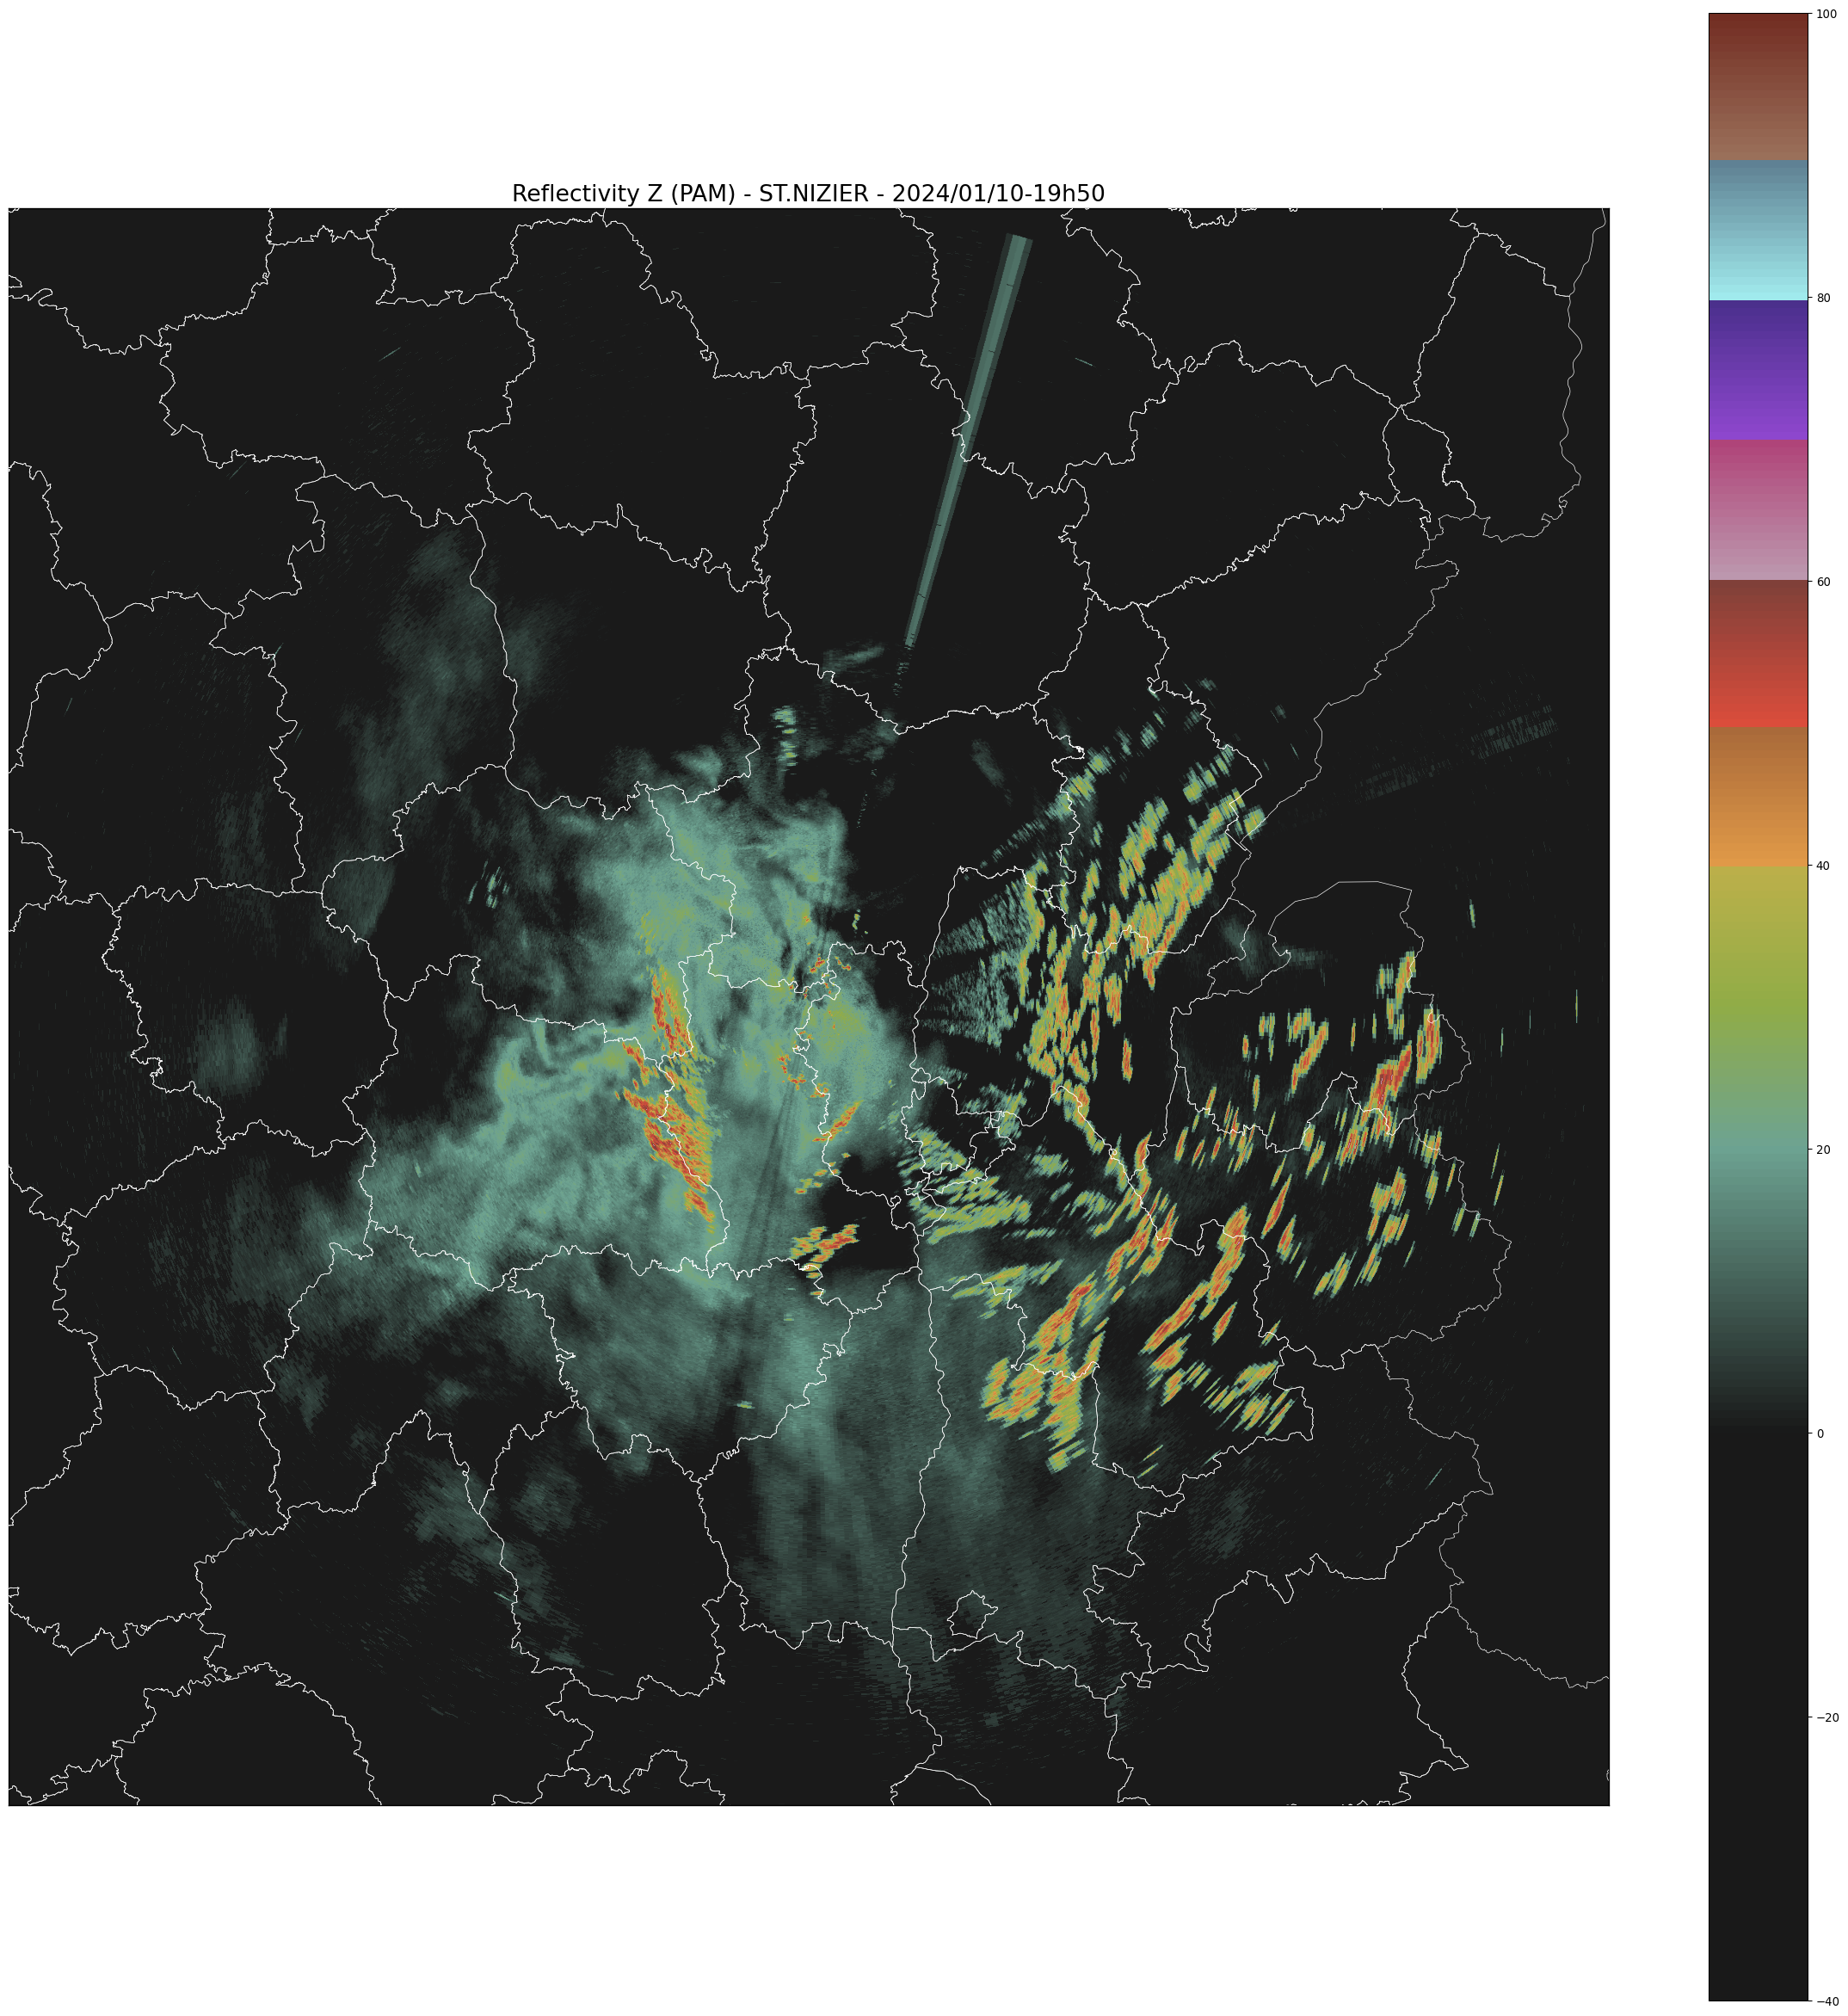

In [115]:
data0 = im0_rad

lat_center = datas_messages[0]['Latitude (high accuracy)'][0] 
lon_center = datas_messages[0]['Longitude (high accuracy)'][0] 
distance_max = (datas_messages[0]['Longueur de la porte distance apres integration'][0] * datas_messages[0]['Number of pixels per row'][0])/1000

# estimation
lat_center_plus = lat_center + distance_max/111.2
lat_center_moins = lat_center - distance_max/111.2
lon_center_plus = lon_center + distance_max/(111.2*np.cos(lat_center*np.pi/180))
lon_center_moins = lon_center - distance_max/(111.2*np.cos(lat_center*np.pi/180))

colors1 = [ (0,"#000000"),(4/14, "#000000")]
colors1 += [(4/14,"#000000"),(6/14, "#5D9986")]
colors1 += [(6/14,"#5D9986"),(7/14, "#84A333")]
colors1 += [(7/14,"#84A333"),(8/14, "#B6A736")]
colors1 += [(8/14,"#DE8F34"),(9/14, "#9D5723")]
colors1 += [(9/14,"#D73925"),(10/14, "#712B23")]
colors1 += [(10/14,"#B691A8"),(11/14, "#A72E69")]
colors1 += [(11/14,"#8434CB"),(12/14, "#35187E")]
colors1 += [(12/14,"#98EBED"),(13/14, "#4A6E83")]
colors1 += [(13/14,"#906149"),(14/14, "#63160A")]
cmap_r = colors.LinearSegmentedColormap.from_list('mycmap', colors1)
norm_r = colors.Normalize(vmin=-40, vmax=100)

nom_radar = liste_radar[int(FILE_NAME.split('_')[1][-2:])]
date_radar = FILE_NAME.split('_')[4]
clabel_r = 'Reflectivity Z (PAM) - ' +   nom_radar + ' - ' + str(date_radar[:4]) + '/' + str(date_radar[4:6]) + '/' + str(date_radar[6:8]) + '-' + str(date_radar[8:10]) + 'h' + str(date_radar[10:12]) 

my_dpi = 96
fig2, ax2 = plt.subplots(1,1, figsize=(3000/my_dpi, 3000/my_dpi), dpi = my_dpi)

map = Basemap(llcrnrlon=lon_center_moins,llcrnrlat=lat_center_moins, urcrnrlon = lon_center_plus, urcrnrlat = lat_center_plus,
             resolution='i', projection='tmerc', lat_0 = lat_center, lon_0 = lon_center)

map.drawmapboundary()
map.readshapefile(os.path.join(dir_shp, file_shp[:-4]), 'departements', color = 'white', zorder = 4)

# Use imshow()
p2=map.imshow(data0[::-1], cmap=cmap_r, norm=norm_r,  alpha=0.9, zorder=3)

fig2.colorbar(p2, ax=ax2,fraction=0.046, pad=0.04)
ax2.set_title(clabel_r, fontsize = 20)

# save the figure
#plt.savefig(FILE_NAME.split('.')[0] + '_reflZ_PAM_dep.png', dpi = my_dpi*2)

## Reflectivity Sigma

In [116]:
k=4
rows = int(datas_messages[k]['Number of pixels per row'][0])
cols = int(datas_messages[k]['Number of pixels per column'][0])

im4_brut = datas_messages[k]['Pixel value (4 bits)']
im4_brut = np.reshape(im4_brut, (cols, rows))
im4_rad = radar_coord_reflSigma(im4_brut,  cols, rows )

In [ ]:
data4 = im4_rad 

colors1 = [ (0,"#000000"),(5/16, "#797979")]
colors1 += [(5/16,"#797979"),(7/16, "#E28431")]
colors1 += [(7/16,"#E28431"),(10/16, "#CC2B1E")]
colors1 += [(10/16,"#CC2B1E"),(12/16, "#AD2318")]
colors1 += [(12/16,"#AD2318"),(16/16, "#9C48C5")]

cmap_s = colors.LinearSegmentedColormap.from_list('mycmap', colors1)
norm_s = colors.Normalize(vmin=0, vmax=16)

nom_radar = liste_radar[int(FILE_NAME.split('_')[1][-2:])]
date_radar = FILE_NAME.split('_')[4]
clabel_s = "Reflectivity Sigma (PAM) - " +   nom_radar + ' - ' + str(date_radar[:4]) + '/' + str(date_radar[4:6]) + '/' + str(date_radar[6:8]) + '-' + str(date_radar[8:10]) + 'h' + str(date_radar[10:12]) 

my_dpi = 96
fig, ax = plt.subplots(figsize=(3000/my_dpi, 3000/my_dpi), dpi = my_dpi)
fig.subplots_adjust()

p = ax.imshow(data4, cmap = cmap_s, norm=norm_s)
plt.axis('off')

cbar = plt.colorbar(p, cmap=cmap_s, location="bottom", pad=0.03, aspect=50)
ax.set_title(clabel_s, fontsize = 25)

#plt.savefig(FILE_NAME.split('.')[0]+'_refl_sigma_PAM.png', dpi = my_dpi)



### Basemap version

In [ ]:
data4 = im4_rad 

lat_center = datas_messages[0]['Latitude (high accuracy)'][0] 
lon_center = datas_messages[0]['Longitude (high accuracy)'][0] 
distance_max = (datas_messages[0]['Longueur de la porte distance apres integration'][0] * datas_messages[0]['Number of pixels per row'][0])/1000

# estimation
lat_center_plus = lat_center + distance_max/111.2
lat_center_moins = lat_center - distance_max/111.2
lon_center_plus = lon_center + distance_max/(111.2*np.cos(lat_center*np.pi/180))
lon_center_moins = lon_center - distance_max/(111.2*np.cos(lat_center*np.pi/180))

colors1 = [ (0,"#000000"),(5/16, "#797979")]
colors1 += [(5/16,"#797979"),(7/16, "#E28431")]
colors1 += [(7/16,"#E28431"),(10/16, "#CC2B1E")]
colors1 += [(10/16,"#CC2B1E"),(12/16, "#AD2318")]
colors1 += [(12/16,"#AD2318"),(16/16, "#9C48C5")]

cmap_s = colors.LinearSegmentedColormap.from_list('mycmap', colors1)

nom_radar = liste_radar[int(FILE_NAME.split('_')[1][-2:])]
date_radar = FILE_NAME.split('_')[4]
clabel_s = "Reflectivity Sigma (PAM) - " +   nom_radar + ' - ' + str(date_radar[:4]) + '/' + str(date_radar[4:6]) + '/' + str(date_radar[6:8]) + '-' + str(date_radar[8:10]) + 'h' + str(date_radar[10:12]) 

my_dpi = 96
fig4, ax4 = plt.subplots(figsize=(3000/my_dpi, 3000/my_dpi), dpi = my_dpi)
map = Basemap(llcrnrlon=lon_center_moins,llcrnrlat=lat_center_moins, urcrnrlon = lon_center_plus, urcrnrlat = lat_center_plus,
             resolution='i', projection='tmerc', lat_0 = lat_center, lon_0 = lon_center)

map.drawmapboundary() #fill_color='aqua')
map.readshapefile(os.path.join(dir_shp, file_shp[:-4]), 'departements', color = 'white', zorder=4)

# Use imshow()
p4=map.imshow(data4[::-1], cmap=cmap_s,  alpha=0.9, zorder=3, vmin = 0, vmax = 16)

ax4.set_title(clabel_s, fontsize = 20)
fig4.colorbar(p4, ax=ax4,fraction=0.046, pad=0.04)

#plt.savefig(FILE_NAME.split('.')[0]+'_refl_sigma_PAM.png', dpi = my_dpi)

## Correlation RhoHV

In [119]:
k=1
rows = int(datas_messages[k]['Number of pixels per row'][0])
cols = int(datas_messages[k]['Number of pixels per column'][0])

im1_brut = datas_messages[k]['Pixel value (4 bits)']
im1_brut = np.reshape(im1_brut, (cols, rows))
im1_rad = radar_transfo(im1_brut,  cols, rows , correl)

In [ ]:
data1 = im1_rad

colors1 = [ (0,"#000000"),(5/11, "#73738D")]
colors1 += [(5/11,"#73738D"),(7/11, "#0619A5")]
colors1 += [(7/11,"#0619A5"),(8/11, "#8182C5")]
colors1 += [(8/11,"#8182C5"),(9/11, "#92C13C")]
colors1 += [(9/11,"#92C13C"),(9.5/11, "#E38632")]
colors1 += [(9.5/11,"#E38632"),(10/11, "#851B37")]
colors1 += [(10/11,"#851B37"),(11/11, "#E3A7C4")]
cmap_c = colors.LinearSegmentedColormap.from_list('mycmap', colors1)
norm_c = colors.Normalize(vmin=0, vmax=1.1)
nom_radar = liste_radar[int(FILE_NAME.split('_')[1][-2:])]
date_radar = FILE_NAME.split('_')[4]
clabel_c = "Correlation RhoHV (PAM)" +   nom_radar + ' - ' + str(date_radar[:4]) + '/' + str(date_radar[4:6]) + '/' + str(date_radar[6:8]) + '-' + str(date_radar[8:10]) + 'h' + str(date_radar[10:12]) 

my_dpi = 96
fig, ax = plt.subplots(figsize=(3000/my_dpi, 3000/my_dpi), dpi = my_dpi)
fig.subplots_adjust()

p = ax.imshow(data1, cmap = cmap_c, norm = norm_c) #vmin=0, vmax = 1.1)
plt.axis('off')
cbar = plt.colorbar(p, cmap=cmap_c,  location="bottom", pad=0.03, aspect=50)
ax.set_title(clabel_c, fontsize = 20)

#plt.savefig(FILE_NAME.split('.')[0]+'_correl_rhoHV_PAM.png', dpi = my_dpi)


### Basemap Version

In [ ]:
data1 = im1_rad 

lat_center = datas_messages[0]['Latitude (high accuracy)'][0] 
lon_center = datas_messages[0]['Longitude (high accuracy)'][0] 
distance_max = (datas_messages[0]['Longueur de la porte distance apres integration'][0] * datas_messages[0]['Number of pixels per row'][0])/1000

# estimation
lat_center_plus = lat_center + distance_max/111.2
lat_center_moins = lat_center - distance_max/111.2
lon_center_plus = lon_center + distance_max/(111.2*np.cos(lat_center*np.pi/180))
lon_center_moins = lon_center - distance_max/(111.2*np.cos(lat_center*np.pi/180))

nom_radar = liste_radar[int(FILE_NAME.split('_')[1][-2:])]
date_radar = FILE_NAME.split('_')[4]
clabel_c = "Correlation RhoHV (PAM)" +   nom_radar + ' - ' + str(date_radar[:4]) + '/' + str(date_radar[4:6]) + '/' + str(date_radar[6:8]) + '-' + str(date_radar[8:10]) + 'h' + str(date_radar[10:12]) 

colors1 = [ (0,"#000000"),(5/11, "#73738D")]
colors1 += [(5/11,"#73738D"),(7/11, "#0619A5")]
colors1 += [(7/11,"#0619A5"),(8/11, "#8182C5")]
colors1 += [(8/11,"#8182C5"),(9/11, "#92C13C")]
colors1 += [(9/11,"#92C13C"),(9.5/11, "#E38632")]
colors1 += [(9.5/11,"#E38632"),(10/11, "#851B37")]
colors1 += [(10/11,"#851B37"),(11/11, "#E3A7C4")]

cmap_c = colors.LinearSegmentedColormap.from_list('mycmap', colors1)
norm_c = colors.Normalize(vmin=0, vmax=1.1)

my_dpi = 96
fig1, ax1 = plt.subplots(figsize=(3000/my_dpi, 3000/my_dpi), dpi = my_dpi)
map = Basemap(llcrnrlon=lon_center_moins,llcrnrlat=lat_center_moins, urcrnrlon = lon_center_plus, urcrnrlat = lat_center_plus,
             resolution='i', projection='tmerc', lat_0 = lat_center, lon_0 = lon_center)

map.drawmapboundary() #fill_color='aqua')
map.readshapefile(os.path.join(dir_shp, file_shp[:-4]), 'departements', color = 'white', zorder=4)
p1=map.imshow(data1[::-1], cmap=cmap_c,  norm = norm_c, alpha=0.9, zorder=3)

ax1.set_title(clabel_c, fontsize = 20)
fig1.colorbar(p1, ax=ax1,fraction=0.046, pad=0.04)

#plt.savefig(FILE_NAME.split('.')[0]+'_correl_rhoHV_PAM.png', dpi = my_dpi)


## Différentielle PHIDP

In [126]:
k=3 
rows = int(datas_messages[k]['Number of pixels per row'][0])
cols = int(datas_messages[k]['Number of pixels per column'][0])

im3_brut = datas_messages[k]['Pixel value (4 bits)']
im3_brut = np.reshape(im3_brut, (cols, rows))

im3_rad = radar_transfo(im3_brut,  cols, rows , phidp)


In [ ]:
data3 = im3_rad 

viridis = cm.get_cmap('gist_ncar', 256)
newcolors = viridis(np.linspace(0, 1, 256))
black = np.array([0, 0, 0, 1])
newcolors[:30, :] = black
cmap_p = colors.ListedColormap(newcolors)
nom_radar = liste_radar[int(FILE_NAME.split('_')[1][-2:])]
date_radar = FILE_NAME.split('_')[4]
clabel_p = "Phase Différentielle PHIDP (PAM)" +   nom_radar + ' - ' + str(date_radar[:4]) + '/' + str(date_radar[4:6]) + '/' + str(date_radar[6:8]) + '-' + str(date_radar[8:10]) + 'h' + str(date_radar[10:12]) 

my_dpi = 96
fig, ax = plt.subplots(figsize=(3000/my_dpi, 3000/my_dpi), dpi = my_dpi)
fig.subplots_adjust()

p = ax.imshow(data3, cmap = cmap_p) #, norm=norm_prob)
plt.axis('off')
cbar = plt.colorbar(p, cmap=cmap_p, location="bottom", pad=0.03, aspect=50)
ax.set_title(clabel_p, fontsize = 20)

#plt.savefig(FILE_NAME.split('.')[0]+'_phase_diff_PHIDP_PAM.png', dpi = my_dpi )


### Basemap Version

In [ ]:
data3 = im3_rad 

lat_center = datas_messages[0]['Latitude (high accuracy)'][0] 
lon_center = datas_messages[0]['Longitude (high accuracy)'][0] 
distance_max = (datas_messages[0]['Longueur de la porte distance apres integration'][0] * datas_messages[0]['Number of pixels per row'][0])/1000

# estimation
lat_center_plus = lat_center + distance_max/111.2
lat_center_moins = lat_center - distance_max/111.2
lon_center_plus = lon_center + distance_max/(111.2*np.cos(lat_center*np.pi/180))
lon_center_moins = lon_center - distance_max/(111.2*np.cos(lat_center*np.pi/180))

viridis = cm.get_cmap('gist_ncar', 256)
newcolors = viridis(np.linspace(0, 1, 256))
black = np.array([0, 0, 0, 1])
newcolors[:30, :] = black
cmap_p = colors.ListedColormap(newcolors)
nom_radar = liste_radar[int(FILE_NAME.split('_')[1][-2:])]
date_radar = FILE_NAME.split('_')[4]
clabel_p = "Phase Différentielle PHIDP (PAM)" +   nom_radar + ' - ' + str(date_radar[:4]) + '/' + str(date_radar[4:6]) + '/' + str(date_radar[6:8]) + '-' + str(date_radar[8:10]) + 'h' + str(date_radar[10:12]) 

my_dpi = 96
fig3, ax3 = plt.subplots(figsize=(3000/my_dpi, 3000/my_dpi), dpi = my_dpi)
map = Basemap(llcrnrlon=lon_center_moins,llcrnrlat=lat_center_moins, urcrnrlon = lon_center_plus, urcrnrlat = lat_center_plus,
             resolution='i', projection='tmerc', lat_0 = lat_center, lon_0 = lon_center)

map.drawmapboundary() #fill_color='aqua')
map.readshapefile(os.path.join(dir_shp, file_shp[:-4]), 'departements', color = 'white', zorder=4)
p3=map.imshow(data3[::-1], cmap=cmap_p,  alpha=0.9, zorder=3)

ax3.set_title(clabel_c, fontsize = 20)
fig3.colorbar(p3, ax=ax3,fraction=0.046, pad=0.04)

#plt.savefig(FILE_NAME.split('.')[0]+'_phase_diff_PHIDP_PAM.png', dpi = my_dpi )


## Reflectivité Différentielle

In [135]:
k=2 
rows = int(datas_messages[k]['Number of pixels per row'][0])
cols = int(datas_messages[k]['Number of pixels per column'][0])

im2_brut = datas_messages[k]['Pixel value (4 bits)']
im2_brut = np.reshape(im2_brut, (cols, rows))
im2_rad = radar_transfo(im2_brut,  cols, rows, refldiff )

In [ ]:
data2 = im2_rad

colors1 = [ (0,"#000000"),(8/16, "#BDBDBD")]
colors1 += [(8/16,"#BDBDBD"),(8.5/16, "#000E89")]
colors1 += [(8.5/16,"#000E89"),(9/16, "#458EC1")]
colors1 += [(9/16,"#458EC1"),(10/16, "#75CA62")]
colors1 += [(10/16,"#75CA62"),(10.5/16, "#EFED73")]
colors1 += [(10.5/16,"#EFED73"),(11/16, "#E28C50")]
colors1 += [(11/16,"#E28C50"),(13/16, "#961D13")]
colors1 += [(13/16,"#961D13"),(15.5/16, "#EAD9E1")]
colors1 += [(15.5/16,"#961D13"),(16/16, "#F0F0F0")]

cmap_d = colors.LinearSegmentedColormap.from_list('mycmap', colors1)
norm_d = colors.Normalize(vmin=-10, vmax=10)
nom_radar = liste_radar[int(FILE_NAME.split('_')[1][-2:])]
date_radar = FILE_NAME.split('_')[4]
clabel_d = "Réflectivité Différentielle Zdr (PAM)" +   nom_radar + ' - ' + str(date_radar[:4]) + '/' + str(date_radar[4:6]) + '/' + str(date_radar[6:8]) + '-' + str(date_radar[8:10]) + 'h' + str(date_radar[10:12]) 

my_dpi = 96
fig2, ax2 = plt.subplots(figsize=(3000/my_dpi, 3000/my_dpi), dpi = my_dpi)
fig2.subplots_adjust()

p2 = ax2.imshow(data2, cmap = cmap_d) #, norm=norm_prob)
plt.axis('off')

cbar = plt.colorbar(p2, cmap=cmap_d, location="bottom", pad=0.03, aspect=50)
ax2.set_title(clabel_d, fontsize = 20)

#plt.savefig(FILE_NAME.split('.')[0]+'_refl_diff_PAM.png', dpi= my_dpi)

### Basemap Version

In [ ]:
data2 = im2_rad 

lat_center = datas_messages[0]['Latitude (high accuracy)'][0] 
lon_center = datas_messages[0]['Longitude (high accuracy)'][0] 
distance_max = (datas_messages[0]['Longueur de la porte distance apres integration'][0] * datas_messages[0]['Number of pixels per row'][0])/1000

# estimation
lat_center_plus = lat_center + distance_max/111.2
lat_center_moins = lat_center - distance_max/111.2
lon_center_plus = lon_center + distance_max/(111.2*np.cos(lat_center*np.pi/180))
lon_center_moins = lon_center - distance_max/(111.2*np.cos(lat_center*np.pi/180))

colors1 = [ (0,"#000000"),(8/16, "#BDBDBD")]
colors1 += [(8/16,"#BDBDBD"),(8.5/16, "#000E89")]
colors1 += [(8.5/16,"#000E89"),(9/16, "#458EC1")]
colors1 += [(9/16,"#458EC1"),(10/16, "#75CA62")]
colors1 += [(10/16,"#75CA62"),(10.5/16, "#EFED73")]
colors1 += [(10.5/16,"#EFED73"),(11/16, "#E28C50")]
colors1 += [(11/16,"#E28C50"),(13/16, "#961D13")]
colors1 += [(13/16,"#961D13"),(15.5/16, "#EAD9E1")]
colors1 += [(15.5/16,"#961D13"),(16/16, "#F0F0F0")]

cmap_d = colors.LinearSegmentedColormap.from_list('mycmap', colors1)
norm_d = colors.Normalize(vmin=-10, vmax=10)
nom_radar = liste_radar[int(FILE_NAME.split('_')[1][-2:])]
date_radar = FILE_NAME.split('_')[4]
clabel_d = "Réflectivité Différentielle Zdr (PAM)" +   nom_radar + ' - ' + str(date_radar[:4]) + '/' + str(date_radar[4:6]) + '/' + str(date_radar[6:8]) + '-' + str(date_radar[8:10]) + 'h' + str(date_radar[10:12]) 

my_dpi = 96
fig2, ax2 = plt.subplots(figsize=(3000/my_dpi, 3000/my_dpi), dpi = my_dpi)
map = Basemap(llcrnrlon=lon_center_moins,llcrnrlat=lat_center_moins, urcrnrlon = lon_center_plus, urcrnrlat = lat_center_plus,
             resolution='i', projection='tmerc', lat_0 = lat_center, lon_0 = lon_center)
map.drawmapboundary()
map.readshapefile(os.path.join(dir_shp, file_shp[:-4]), 'departements', color = 'white', zorder=4)
p2=map.imshow(data2[::-1], cmap=cmap_d,  norm = norm_d, alpha=0.9, zorder=3)

ax2.set_title(clabel_d, fontsize = 20)
fig2.colorbar(p2, ax=ax2,fraction=0.046, pad=0.04)

#plt.savefig(FILE_NAME.split('.')[0]+'_refl_diff_PAM.png', dpi= my_dpi)


## Advection (a priori absente des fichiers PAM)?

In [35]:
k=4 # same data as the Reflectivity Sigma
rows = int(datas_messages[k]['Number of pixels per row'][0])
cols = int(datas_messages[k]['Number of pixels per column'][0])

im4b_brut = datas_messages[k]['Pixel value (4 bits)']
im4b_brut = np.reshape(im4b_brut, (cols, rows))
im4b_rad = radar_coord_adv(im4b_brut,  cols, rows )

In [ ]:
data4b = im4b_rad 

clabel_p = "Advection (PAM)"

viridis = cm.get_cmap('gist_ncar', 256)
newcolors = viridis(np.linspace(0, 1, 256))
black = np.array([0, 0, 0, 1])
newcolors[:30, :] = black
cmap_p = colors.ListedColormap(newcolors)

my_dpi = 96
fig, ax = plt.subplots(figsize=(3000/my_dpi, 3000/my_dpi), dpi = my_dpi)
fig.subplots_adjust()

p = ax.imshow(data4b, cmap = cmap_p) #, norm=norm_prob)
plt.axis('off')

cbar = plt.colorbar(p, cmap=cmap_p, location="bottom", pad=0.03, aspect=50)
ax.set_title(clabel_p, fontsize = 20)

plt.savefig(FILE_NAME+'_advecation.png', dpi = my_dpi)


# PROGRAM FOR INDIVIDUALS RADARS (PAG)

In [58]:
# bufr file to decode
DIR_PATH = r'C:\Users\thepe\Documents\Data_Analyse\Meteo_France_API'

FILE_NAME = 'T_PAGF58_C_EODC_20240110195500.bufr.gz'
#FILE_NAME = 'T_PAGF51_C_EODC_20240129132500.bufr.gz'
#FILE_NAME = 'T_PAGA63_C_EODC_20240129154000.bufr.gz'
#FILE_NAME = 'T_PAGA55_C_EODC_20240129162500.bufr.gz'
#FILE_NAME = 'T_PAGC92_C_EODC_20240131104000.bufr.gz'

# directory of the tables and local tables
DIR_PATH_TABLE = r'C:\Users\thepe\Documents\BUFR32\MeteoFranceTables'

# if you want to see all the descriptors (but lot of prints !!)
affiche_descriptors = False

FIC_TAB_B = 'bufrtabb_{master}.csv'
FIC_TAB_D = 'bufrtabd_{master}.csv'
FIC_LOCAL_TAB_B = 'localtabb_{center}_{local}.csv'
FIC_LOCAL_TAB_D = 'localtabd_{center}_{local}.csv'


In [59]:
deco_bufr()

 ----------- BEGIN OF BUFR MESSAGE n° 0  -----------
BUFR
Total length of Bufr message in bytes :  185038
Bufr Edition number :  2
Length of section 1 :  28
Bufr master table :  0
Identification of originating/generating sub-centre :  0
Identification of originating/generating centre :  85
Update sequence number :  0
Optional (1) / No Optional (0) section follows :  0
Data Category (Table A) :  6
Data category sub-category :  0
Version number of master table used :  11
Version number of local tables used :  12
Year :  24
Month :  1
Day :  10
Hour :  19
Minute :  54
SECTION 2 : 
2   
202   Ê
0    
1   
76   L
70   F
78   N
73   I
90   Z
73   I
0    
FIN SECTION 2
Length of section 3 (Data Description) :  156
Number of data subsets :  1
Observed/Compressed Data :  1 / 0
Length of section 4 (Datas) :  184842
* REPETITIONS *
   number of descriptors replicated  5  and number of replications =  3
* REPETITIONS *
   number of descriptors replicated  2  and number of replications =  1
* REP

In [140]:
print("Number of available pictures : " , len(datas_messages))
for k in range(len(datas_messages)):
    print("Image ",k, ':', len(datas_messages[k]['Pixel value (4 bits)']), ' values on ', int(datas_messages[k]['Number of pixels per row'][0]), ' lignes(gates) x ', int(datas_messages[k]['Number of pixels per column'][0]), ' colonnes(azimuts)')
    print('  min value = ', min(datas_messages[k]['Pixel value (4 bits)']), ' and max value = ', max(datas_messages[k]['Pixel value (4 bits)']))
    

Number of available pictures :  3
Image  0 : 184400  values on  256  lignes(gates) x  720  colonnes(azimuts)
  min value =  0.0  and max value =  79.0
Image  1 : 92160  values on  256  lignes(gates) x  360  colonnes(azimuts)
  min value =  0.0  and max value =  32.0
Image  2 : 92160  values on  256  lignes(gates) x  360  colonnes(azimuts)
  min value =  0.0  and max value =  255.0


## Horizontal Reflectivity Z

In [141]:
k=0
rows = int(datas_messages[k]['Number of pixels per row'][0])
cols = int(datas_messages[k]['Number of pixels per column'][0])
bruitZ = [-12] #datas_messages[k]['Minimum detectable signal'][0] ??
im0_brut = datas_messages[k]['Pixel value (4 bits)'][80:]
im0_brut = np.reshape(im0_brut, (cols, rows))
im0_rad = radar_transfo_bruit(im0_brut,  cols, rows , reflZ, [bruitZ*rows]*cols)


In [ ]:
data0 = im0_rad 

colors1 = [ (0,"#000000"),(4/14, "#000000")]
colors1 += [(4/14,"#000000"),(6/14, "#5D9986")]
colors1 += [(6/14,"#5D9986"),(7/14, "#84A333")]
colors1 += [(7/14,"#84A333"),(8/14, "#B6A736")]
colors1 += [(8/14,"#DE8F34"),(9/14, "#9D5723")]
colors1 += [(9/14,"#D73925"),(10/14, "#712B23")]
colors1 += [(10/14,"#B691A8"),(11/14, "#A72E69")]
colors1 += [(11/14,"#8434CB"),(12/14, "#35187E")]
colors1 += [(12/14,"#98EBED"),(13/14, "#4A6E83")]
colors1 += [(13/14,"#906149"),(14/14, "#63160A")]

cmap_r = colors.LinearSegmentedColormap.from_list('mycmap', colors1)
norm_r = colors.Normalize(vmin=-40, vmax=100)
nom_radar = liste_radar[int(FILE_NAME.split('_')[1][-2:])]
date_radar = FILE_NAME.split('_')[4]
clabel_r = 'Reflectivity Z (PAG) - ' +   nom_radar + ' - ' + str(date_radar[:4]) + '/' + str(date_radar[4:6]) + '/' + str(date_radar[6:8]) + '-' + str(date_radar[8:10]) + 'h' + str(date_radar[10:12]) 

                                                                                 
my_dpi = 96
fig0, ax0 = plt.subplots(figsize=(3000/my_dpi, 3000/my_dpi), dpi = my_dpi)
fig0.subplots_adjust()    
p0 = ax0.imshow(data0, cmap = cmap_r, norm=norm_r)
plt.axis('off')
cbar = plt.colorbar(p0, cmap= cmap_r, location="bottom", pad=0.03, aspect=50)
ax0.set_title(clabel_r, fontsize = 20)

#plt.savefig(FILE_NAME.split('.')[0] + '_refl_PAG.png', dpi = my_dpi*2)


### Basemap Version

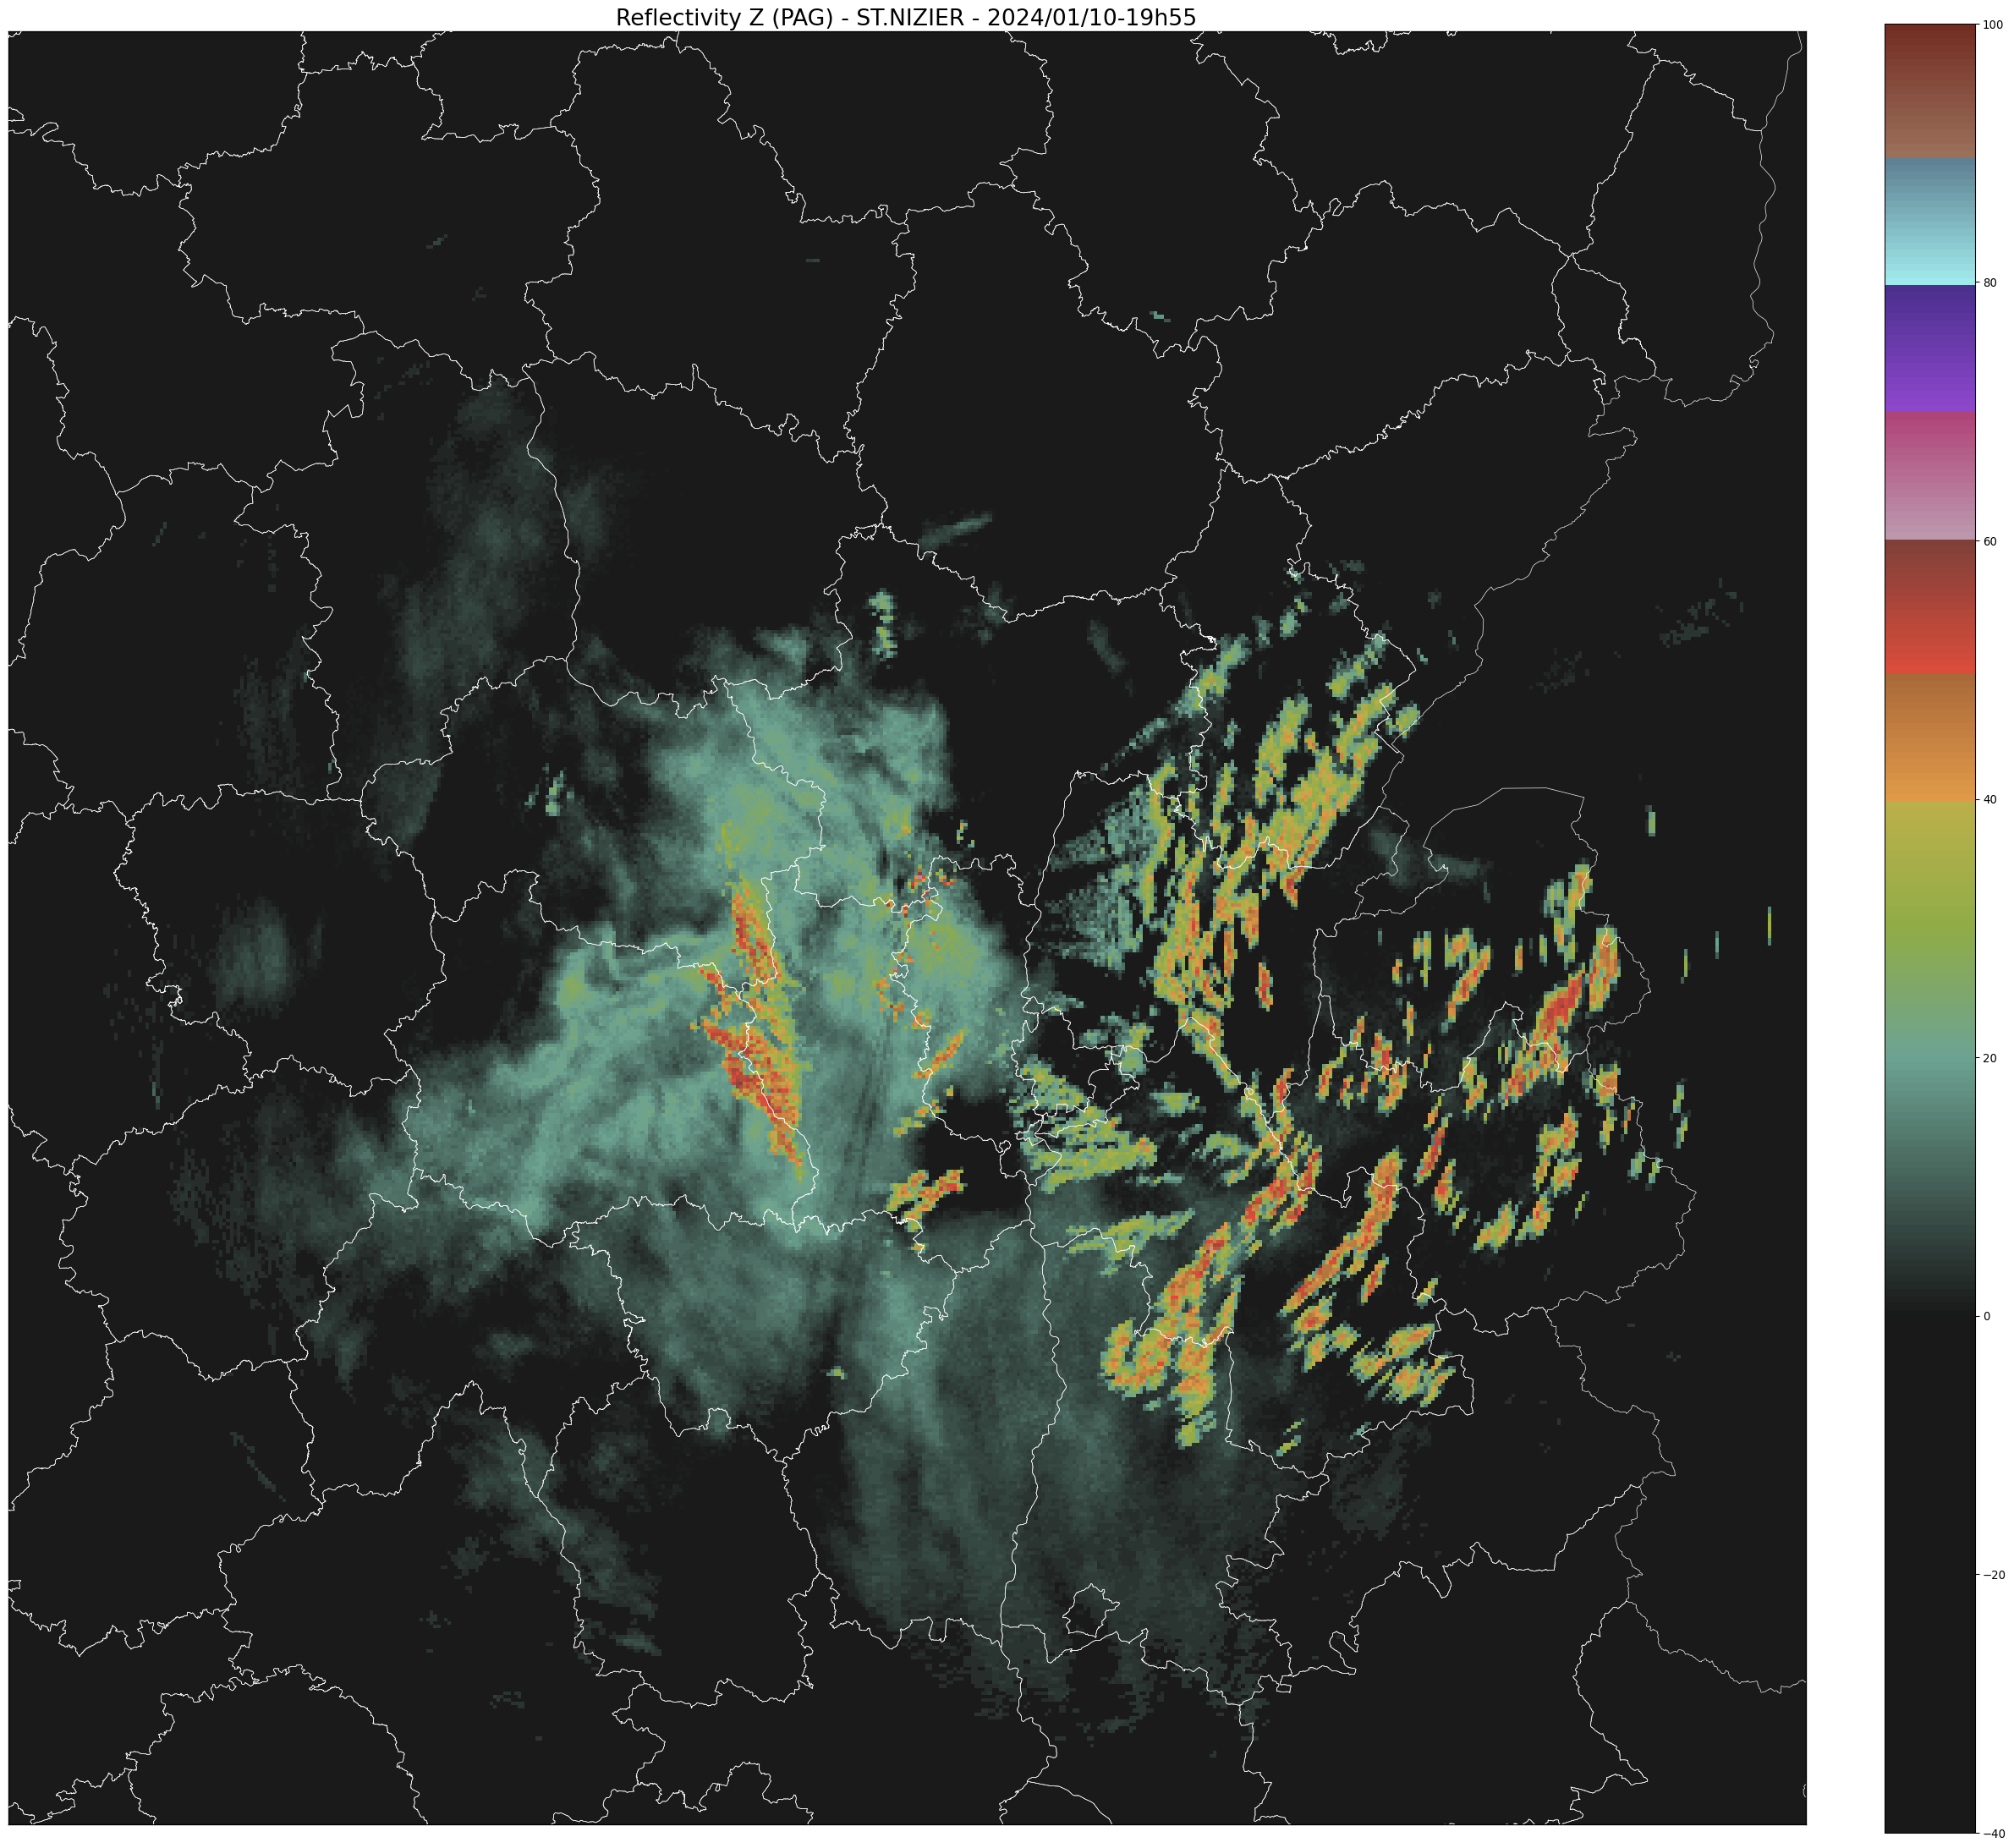

In [153]:
data0 = im0_rad

lat_center = datas_messages[0]['Latitude (high accuracy)'][0] 
lon_center = datas_messages[0]['Longitude (high accuracy)'][0] 
distance_max = datas_messages[0]['Longueur de la porte distance apres integration'][0] * datas_messages[0]['Number of pixels per row'][0] /1000

# estimation
lat_center_plus = lat_center + distance_max/111.2
lat_center_moins = lat_center - distance_max/111.2
lon_center_plus = lon_center + distance_max/(111.2*np.cos(lat_center*np.pi/180))
lon_center_moins = lon_center - distance_max/(111.2*np.cos(lat_center*np.pi/180))

colors1 = [ (0,"#000000"),(4/14, "#000000")]
colors1 += [(4/14,"#000000"),(6/14, "#5D9986")]
colors1 += [(6/14,"#5D9986"),(7/14, "#84A333")]
colors1 += [(7/14,"#84A333"),(8/14, "#B6A736")]
colors1 += [(8/14,"#DE8F34"),(9/14, "#9D5723")]
colors1 += [(9/14,"#D73925"),(10/14, "#712B23")]
colors1 += [(10/14,"#B691A8"),(11/14, "#A72E69")]
colors1 += [(11/14,"#8434CB"),(12/14, "#35187E")]
colors1 += [(12/14,"#98EBED"),(13/14, "#4A6E83")]
colors1 += [(13/14,"#906149"),(14/14, "#63160A")]
cmap_r = colors.LinearSegmentedColormap.from_list('mycmap', colors1)
norm_r = colors.Normalize(vmin=-40, vmax=100)

nom_radar = liste_radar[int(FILE_NAME.split('_')[1][-2:])]
date_radar = FILE_NAME.split('_')[4]
clabel_r = 'Reflectivity Z (PAG) - ' +   nom_radar + ' - ' + str(date_radar[:4]) + '/' + str(date_radar[4:6]) + '/' + str(date_radar[6:8]) + '-' + str(date_radar[8:10]) + 'h' + str(date_radar[10:12]) 

my_dpi = 96
fig0, ax0 = plt.subplots(1,1, figsize=(3000/my_dpi, 3000/my_dpi), dpi = my_dpi)

map = Basemap(llcrnrlon=lon_center_moins,llcrnrlat=lat_center_moins, urcrnrlon = lon_center_plus, urcrnrlat = lat_center_plus,
             resolution='i', projection='tmerc', lat_0 = lat_center, lon_0 = lon_center)

map.drawmapboundary()
map.readshapefile(os.path.join(dir_shp, file_shp[:-4]), 'departements', color = 'white', zorder = 4)
# Use imshow()
p0=map.imshow(data0[::-1], cmap=cmap_r, norm=norm_r,  alpha=0.9, zorder=3)

fig0.colorbar(p0, ax=ax0,fraction=0.046, pad=0.04)
ax0.set_title(clabel_r, fontsize = 20)

# save the figure
#plt.savefig(FILE_NAME.split('.')[0] + '_reflZ_PAG_dep.png', dpi = my_dpi*2)

## Sigma Polaire

In [144]:
k=1
rows = int(datas_messages[k]['Number of pixels per row'][0])
cols = int(datas_messages[k]['Number of pixels per column'][0])

im1_brut = datas_messages[k]['Pixel value (4 bits)']
im1_brut = np.reshape(im1_brut, (cols, rows))
im1_rad = radar_transfo(im1_brut,  cols, rows , reflSigma)

In [ ]:
data1 = im1_rad

cmap_r = colors.ListedColormap(['silver','white', 'darkslateblue', 'mediumblue','dodgerblue', 
                              'skyblue','olive','mediumseagreen','cyan','lime','yellow',
                              'khaki','burlywood','orange','brown','pink','red','plum', 'black'])

viridis = cm.get_cmap('gist_ncar', 256)
newcolors = viridis(np.linspace(0, 1, 256))
black = np.array([0, 0, 0, 1])
#newcolors[:30, :] = black
cmap_r = colors.ListedColormap(newcolors)

nom_radar = liste_radar[int(FILE_NAME.split('_')[1][-2:])]
date_radar = FILE_NAME.split('_')[4]
clabel_r = 'Sigma Polaire (PAG)' +   nom_radar + ' - ' + str(date_radar[:4]) + '/' + str(date_radar[4:6]) + '/' + str(date_radar[6:8]) + '-' + str(date_radar[8:10]) + 'h' + str(date_radar[10:12]) 

my_dpi = 96
fig, ax = plt.subplots(figsize=(3000/my_dpi, 3000/my_dpi), dpi = my_dpi)
fig.subplots_adjust()

p = ax.imshow(data1, cmap_r) #, norm=norm_r)
plt.axis('off')

cbar = plt.colorbar(p, cmap=cmap_r, location="bottom", pad=0.03, aspect=50)
ax.set_title(clabel_r, fontsize = 20)

#plt.savefig(FILE_NAME.split('.')[0] + '_SigmaPol_PAG.png', dpi = my_dpi)

### Basemap Version

In [ ]:
data1 = im1_rad


lat_center = datas_messages[0]['Latitude (high accuracy)'][0] 
lon_center = datas_messages[0]['Longitude (high accuracy)'][0] 
distance_max = datas_messages[0]['Longueur de la porte distance apres integration'][0] * datas_messages[0]['Number of pixels per row'][0] /1000

# estimation
lat_center_plus = lat_center + distance_max/111.2
lat_center_moins = lat_center - distance_max/111.2
lon_center_plus = lon_center + distance_max/(111.2*np.cos(lat_center*np.pi/180))
lon_center_moins = lon_center - distance_max/(111.2*np.cos(lat_center*np.pi/180))

viridis = cm.get_cmap('gist_ncar', 256)
newcolors = viridis(np.linspace(0, 1, 256))
black = np.array([0, 0, 0, 1])
#newcolors[:30, :] = black
cmap_r = colors.ListedColormap(newcolors)
#norm_r = colors.Normalize(vmin=0, vmax=16)

nom_radar = liste_radar[int(FILE_NAME.split('_')[1][-2:])]
date_radar = FILE_NAME.split('_')[4]
clabel_r = 'Sigma Polaire (PAG) - ' +   nom_radar + ' - ' + str(date_radar[:4]) + '/' + str(date_radar[4:6]) + '/' + str(date_radar[6:8]) + '-' + str(date_radar[8:10]) + 'h' + str(date_radar[10:12]) 

my_dpi = 96
fig1, ax1 = plt.subplots(1,1, figsize=(3000/my_dpi, 3000/my_dpi), dpi = my_dpi)

map = Basemap(llcrnrlon=lon_center_moins,llcrnrlat=lat_center_moins, urcrnrlon = lon_center_plus, urcrnrlat = lat_center_plus,
             resolution='i', projection='tmerc', lat_0 = lat_center, lon_0 = lon_center)
map.drawmapboundary()
map.readshapefile(os.path.join(dir_shp, file_shp[:-4]), 'departements', color = 'white', zorder = 4)
# Use imshow()
p1=map.imshow(data1[::-1], cmap=cmap_r,  alpha=0.9, zorder=3) # ,norm=norm_r

fig1.colorbar(p1, ax=ax1,fraction=0.046, pad=0.04)
ax1.set_title(clabel_r, fontsize = 20)

# save the figure
#plt.savefig(FILE_NAME.split('.')[0] + '_SigmaPol_PAG.png', dpi = my_dpi*2)

## VitVraiPol

In [149]:
k=2
rows = int(datas_messages[k]['Number of pixels per row'][0])
cols = int(datas_messages[k]['Number of pixels per column'][0])
bruitZ = -12 #datas_messages[k]['Minimum detectable signal'][0]
im2_brut = datas_messages[k]['Pixel value (4 bits)']
im2_brut = np.reshape(im2_brut, (cols, rows))
im2_rad = radar_transfo(im2_brut, cols, rows, vitvraipol )

In [ ]:
data2 = im2_rad

colors1 = plt.cm.gist_ncar(np.linspace(0.1, 0.75, 64))
colors2 = plt.cm.gist_ncar_r(np.linspace(0.25, 0.9, 64))
colors4 = plt.cm.Reds(np.linspace(0.6,1,128))
colors5 = plt.cm.Reds_r(np.linspace(0,0.4,128))

# combine them and build a new colormap
colors3 = np.vstack((colors5, colors2, colors1, colors4))
cmap_r = colors.LinearSegmentedColormap.from_list('mycmap', colors3)
norm_r = colors.Normalize(vmin=-60, vmax=60)

nom_radar = liste_radar[int(FILE_NAME.split('_')[1][-2:])]
date_radar = FILE_NAME.split('_')[4]
clabel_r = 'Vitesses Radiales Polaires (PAG)' +   nom_radar + ' - ' + str(date_radar[:4]) + '/' + str(date_radar[4:6]) + '/' + str(date_radar[6:8]) + '-' + str(date_radar[8:10]) + 'h' + str(date_radar[10:12]) 

fig2, ax2 = plt.subplots(figsize=(14, 14))
fig2.subplots_adjust()

p2 = ax2.imshow(data2, cmap_r, norm=norm_r)
plt.axis('off')

cbar = plt.colorbar(p2, cmap=cmap_r, location="bottom", pad=0.03, aspect=50)
ax2.set_title(clabel_r, fontsize = 20)

#plt.savefig(FILE_NAME.split('.')[0]+'_VitVraiPol_PAG.png')

### Basemap Version

In [ ]:
data2 = im2_rad


lat_center = datas_messages[0]['Latitude (high accuracy)'][0] 
lon_center = datas_messages[0]['Longitude (high accuracy)'][0] 
distance_max = datas_messages[0]['Longueur de la porte distance apres integration'][0] * datas_messages[0]['Number of pixels per row'][0] /1000

# estimation
lat_center_plus = lat_center + distance_max/111.2
lat_center_moins = lat_center - distance_max/111.2
lon_center_plus = lon_center + distance_max/(111.2*np.cos(lat_center*np.pi/180))
lon_center_moins = lon_center - distance_max/(111.2*np.cos(lat_center*np.pi/180))


colors1 = plt.cm.gist_ncar(np.linspace(0.1, 0.75, 64))
colors2 = plt.cm.gist_ncar_r(np.linspace(0.25, 0.9, 64))
colors4 = plt.cm.Reds(np.linspace(0.6,1,128))
colors5 = plt.cm.Reds_r(np.linspace(0,0.4,128))

# combine them and build a new colormap
colors3 = np.vstack((colors5, colors2, colors1, colors4))
cmap_r = colors.LinearSegmentedColormap.from_list('mycmap', colors3)

norm_r = colors.Normalize(vmin=-60, vmax=60)

nom_radar = liste_radar[int(FILE_NAME.split('_')[1][-2:])]
date_radar = FILE_NAME.split('_')[4]
clabel_r = 'Vitesses Radiales Polaires (PAG) - ' +   nom_radar + ' - ' + str(date_radar[:4]) + '/' + str(date_radar[4:6]) + '/' + str(date_radar[6:8]) + '-' + str(date_radar[8:10]) + 'h' + str(date_radar[10:12]) 

my_dpi = 96
fig2, ax2 = plt.subplots(1,1, figsize=(3000/my_dpi, 3000/my_dpi), dpi = my_dpi)

map = Basemap(llcrnrlon=lon_center_moins,llcrnrlat=lat_center_moins, urcrnrlon = lon_center_plus, urcrnrlat = lat_center_plus,
             resolution='i', projection='tmerc', lat_0 = lat_center, lon_0 = lon_center)
map.drawmapboundary()
map.readshapefile(os.path.join(dir_shp, file_shp[:-4]), 'departements', color = 'white', zorder = 4)
# Use imshow()
p2=map.imshow(data2[::-1], cmap=cmap_r, norm=norm_r,  alpha=0.9, zorder=3)

fig2.colorbar(p2, ax=ax2,fraction=0.046, pad=0.04)
ax2.set_title(clabel_r, fontsize = 20)

# save the figure
#plt.savefig(FILE_NAME.split('.')[0]+'_VitVraiPol_PAG.png')
